<a href="https://colab.research.google.com/github/deep1003/deep1003/blob/master/Patent_analysis_LLM_1(en).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Investigation of Global LLM Patent Enbeddubg Space and South Korea’s Strategic Position**

## **Objectives**


*   To characterize the global distribution of large‑language‑model (LLM) patents via embedding‑based clustering.
*   To identify South Korea’s central and peripheral innovations within the global patent embedding space.
*   To elucidate South Korea’s role in the international co‑inventor network and assess its collaborative positioning.
*   To derive strategic insights for national R&D policy and collaborative initiatives.

## **Problem Statement**
*   Conventional patent‐metric analyses inadequately capture latent semantic relationships and collaboration structures in the rapidly evolving LLM domain.
* South Korea’s inventive output, though significant, risks marginalization within larger national clusters.
* A hybrid embedding‐network approach is needed to (i) surface nuanced positional insights and (ii) reveal collaboration dynamics that traditional counts or citation tallies overlook.
* Technically, representing long patent texts in vector space is constrained by the model’s maximum token limit.

## **Methodology**
### **Patent Vector Embedding**
* (1) Concatenates the title, abstract, and main claim of each patent into a single string for embedding.
* (2) A Sentence-BERT model applies mean pooling to generate fixed-length semantic vectors (We use the sentence-transformers/all-MiniLM-L6-v2 due to the lack of computing resources).
* Reduce dimensionality via PCA, preserving pairwise semantic proximities.
### **Core vs. Periphery Selection**
* Compute the centroid of South Korean patent embeddings; partition patents by distance to centroid.
* From each partition, select the top three patents by cited_by_count to represent core and peripherial innovations.
### **Co‑Inventor Network Analysis**
* Filter LLM patents by application year; aggregate inventors per patent.
* Construct a weighted undirected graph (edges = joint applications; weights = co‑filing frequency).
* Extract the top 150 inventors by weighted degree; annotate South Korea’s inventors to determine their bridging roles.
### **Visualization and Interpretation**
* Generate two PCA scatterplots with fixed axes: global distribution and Korean highlights (core/outliers).
* Visualize the co‑inventor graph with country‐coded nodes and edge thickness proportional to collaboration intensity.
* Synthesize findings to recommend targeted R&D collaboration and policy interventions.
This integrated semantic‑network framework provides a rigorous basis for evaluating national patent strategies and fostering high‑impact collaborations in LLM research.

In [1]:
# Colab Shortcuts
# Ctrl + S    : Save notebook
# Ctrl + Enter    : Run current cell
# Ctrl + Shift + Enter    : Run selected code only
# Ctrl + F9    : Run all cells
# Ctrl + F8    : Run all cells above and including current
# Ctrl + F10   : Run current cell and all cells below
# Ctrl + /    : Toggle comment on selected lines


##**1. Drive Mount & Library Import**

In [ ]:
# Install required packages (run once at the start)
!pip install pandas numpy networkx matplotlib python-louvain pyvis pycountry rapidfuzz adjustText

In [3]:
# 1. Mount Google Drive (to read/write files)
from google.colab import drive
drive.mount('/content/drive')  # mounts your Drive at /content/drive
# 2. Set the data directory path
base_dir = '/content/drive/MyDrive/data1'  # path where the CSV files are stored

Mounted at /content/drive


In [4]:
# Press Ctrl + F10 to run all cells from this one; for more shortcuts, click Runtime at the top
import pandas as pd  # DataFrame operations
import numpy as np  # Array operations
import time      # For timing
import matplotlib.pyplot as plt  # Matplotlib: MATLAB‑style 2D plotting
import networkx as nx          # NetworkX: network analysis
import seaborn as sns          # Seaborn: statistical data visualization
import pycountry               # pycountry: ISO country code and information
import os                  # os: operating system interfaces for file paths, environment variables, etc.
from glob import glob      # glob: utility for file pattern matching
from sklearn.model_selection import train_test_split  # For stratified splitting
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE


In [5]:
# Cell 1: List and filter CSV files from Google Drive

base_dir = '/content/drive/My Drive/data1'  # base_dir: path to the data folder

# Tuple of prefixes to select files starting with '43', '44', etc.
prefixes = ('36','37', '38', '39', '40', '41', '42', '43', '44')

# Gather all .csv file paths under base_dir
all_csv = glob(os.path.join(base_dir, '*.csv'))  # os.path.join: join directory and pattern

# Filter files whose basename starts with any of the specified prefixes
csv_files = [
    f for f in all_csv
    if os.path.basename(f).startswith(prefixes)
]

# Print the number of files found and their basenames
print(f'Found {len(csv_files)} files:')
for f in csv_files:
    print('  -', os.path.basename(f))


Found 13 files:
  - 39.MachineTranslation.csv
  - 37.Diaglogue.csv
  - 40.Morphology.csv
  - 38.IE.csv
  - 43.Semantics.csv
  - 42.NLP(General)_1.csv
  - 42.NLP(General)_3.csv
  - 42.NLP(General)_2.csv
  - 42.NLP(General)_4.csv
  - 44.SentimentAnalysis.csv
  - 36.NLP_1.csv
  - 36.NLP_2.csv
  - 41.NLG.csv


## **2. Read CSV Files and Remove Duplicates**

In [6]:
# Cell 2: Read CSV files and remove duplicates

df_list = []  # List to hold individual CSV DataFrames

# Attempt to read each file using various encodings
for f in csv_files:
    for enc in ('utf-8', 'cp949', 'latin1'):
        try:
            # Read the CSV with the specified encoding
            df = pd.read_csv(f, encoding=enc)
            print(f'{os.path.basename(f)} read successfully (encoding={enc})')
            df_list.append(df)  # Add the read DataFrame to the list
            break               # Move to the next file on success
        except Exception:
            continue            # Try the next encoding on failure

# Concatenate all DataFrames and drop exact duplicate rows
combined_df = pd.concat(df_list, ignore_index=True).drop_duplicates()
print(f'Total rows after merging: {len(combined_df)}')


39.MachineTranslation.csv read successfully (encoding=cp949)
37.Diaglogue.csv read successfully (encoding=cp949)
40.Morphology.csv read successfully (encoding=cp949)
38.IE.csv read successfully (encoding=cp949)
43.Semantics.csv read successfully (encoding=cp949)
42.NLP(General)_1.csv read successfully (encoding=cp949)
42.NLP(General)_3.csv read successfully (encoding=cp949)
42.NLP(General)_2.csv read successfully (encoding=cp949)
42.NLP(General)_4.csv read successfully (encoding=cp949)
44.SentimentAnalysis.csv read successfully (encoding=cp949)
36.NLP_1.csv read successfully (encoding=cp949)
36.NLP_2.csv read successfully (encoding=cp949)
41.NLG.csv read successfully (encoding=cp949)
Total rows after merging: 46807


In [7]:
combined_df.shape  # DataFrame

(46807, 45)

In [8]:
combined_df.info()  # DataFrame Column, Non-Null Count, Data Type

<class 'pandas.core.frame.DataFrame'>
Index: 46807 entries, 0 to 58155
Data columns (total 45 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   국가코드                        46807 non-null  object 
 1   DB종류                        46807 non-null  object 
 2   특허/실용 구분                    46807 non-null  object 
 3   문헌종류 코드                     46807 non-null  object 
 4   발명의 명칭                      46807 non-null  object 
 5   발명의 명칭-번역문                  44379 non-null  object 
 6   요약                          46785 non-null  object 
 7   요약-번역문                      44352 non-null  object 
 8   대표청구항                       46807 non-null  object 
 9   대표청구항-번역문                   44378 non-null  object 
 10  독립청구항[KR,JP,US,CN,EP,IN]    46807 non-null  object 
 11  독립청구항-번역문[JP,US,CN,EP]      44377 non-null  object 
 12  청구항 수                       46807 non-null  int64  
 13  출원번호                        46807 no

## **3. Column Name Mapping (Korean → English)**

In [9]:
# Cell 3: Column name mapping (Korean → English)
import pandas as pd  # Use pandas for DataFrame operations

# 1) Apply column mapping to combined_df
orig = combined_df.columns.tolist()  # List of original column names

# List of new English column names with bilingual comments for each
new = [
    "PTO_id",                 # 국가코드 (Country code)
    "PTO_type",               # DB종류 (Database type)
    "patent_kind",            # 특허/실용 구분 (Patent vs utility model)
    "pub_type_code",          # 문헌종류 코드 (Publication type code)
    "title",                  # 발명의 명칭 (Invention title)
    "title_en",               # 발명의 명칭-번역문 (Invention title – translation)
    "abstract",               # 요약 (Abstract)
    "abstract_en",            # 요약-번역문 (Abstract – translation)
    "claim_main",             # 대표청구항 (Main claim)
    "claim_main_en",          # 대표청구항-번역문 (Main claim – translation)
    "claims_indep",           # 독립청구항[KR,JP,US,CN,EP,IN] (Independent claims [KR, JP, US, CN, EP, IN])
    "claims_indep_en",        # 독립청구항-번역문[JP,US,CN,EP] (Independent claims – translation [JP, US, CN, EP])
    "num_claims",             # 청구항 수 (Number of claims)
    "appl_id",                # 출원번호 (Application number)
    "appl_date",              # 출원일 (Application date)
    "pub_id",                 # 공개번호 (Publication number)
    "pub_date",               # 공개일 (Publication date)
    "grant_id",               # 등록번호 (Grant number)
    "grant_date",             # 등록일 (Grant date)
    "applicant",              # 출원인 (Applicant)
    "inventor",               # 발명자 (Inventor)
    "citations_count",        # 인용 문헌 수(B1) (Citations count (B1))
    "citation_ids",           # 인용 문헌번호(B1) (Citation IDs (B1))
    "cited_by_count",         # 피인용 문헌 수(F1) (Cited-by count (F1))
    "cited_by_ids",           # 피인용 문헌번호(F1) (Cited-by IDs (F1))
    "wips_family_id",         # WIPS패밀리 ID (WIPS family ID)
    "wips_family_pub_ids",    # WIPS패밀리 문헌번호(출원기준) (WIPS family publication IDs)
    "wips_family_pub_count",  # WIPS패밀리 문헌 수(출원기준) (WIPS family publication count)
    "status_info",            # 상태정보[KR,JP,US,EP,CN,CA,AU] (Status info [KR, JP, US, EP, CN, CA, AU])
    "current_owner",          # 현재권리자[KR,JP,US,CN,CA,AU] (Current owner [KR, JP, US, CN, CA, AU])
    "num_applicants",         # 출원인 수 (Number of applicants)
    "applicant_nat",          # 출원인 국적 (Applicant nationality)
    "applicant_main_code",    # 출원인 대표명화 코드 (Applicant main name code)
    "applicant_main_name_en", # 출원인 대표명화 영문명 (Applicant main name – English)
    "inventor_nat",           # 발명자 국적 (Inventor nationality)
    "num_inventors",          # 발명자 수 (Number of inventors)
    "cpc_main",               # Current CPC Main
    "cpc_all",                # Current CPC All
    "ipc_main",               # Current IPC Main
    "ipc_all",                # Current IPC All
    "orig_cpc_main",          # Original CPC Main
    "orig_cpc_all",           # Original CPC All
    "orig_ipc_main",          # Original IPC Main
    "orig_ipc_all",           # Original IPC All
    "wintelips_key"           # Wintelips key
]

# Verify that the number of original and new column names match
assert len(orig) == len(new), "Mismatch in number of columns"

# Apply the new column names
combined_df.columns = new

# 2) Sort combined_df by 'inventor_nat' in descending order and reset index
if 'inventor_nat' in combined_df.columns:
    combined_df = (
        combined_df
        .sort_values(by='inventor_nat', ascending=False)
        .reset_index(drop=True)
    )
else:
    combined_df = combined_df.copy()

In [10]:
# Check the results
display(combined_df[['appl_id', 'applicant', 'applicant_nat', 'inventor', 'inventor_nat', 'cited_by_count', 'appl_date']].head(1))

appl_id                                    applicant applicant_nat  \
0  16/887692  INTERNATIONAL BUSINESS MACHINES CORPORATION            US   

                                            inventor       inventor_nat  \
0  Maletsabisa Molapo | Chane Simone Moodley | Si...  ZA | ZA | ZA | ZA   

   cited_by_count   appl_date  
0               1  2020-05-29

In [11]:
#combined_df.describe()

In [12]:
#combined_df.isnull().sum()

In [13]:
combined_df.duplicated().sum()  # Check the duplicated rows

np.int64(0)

## **4. Remove Un-related Applicants**

In [14]:
# Cell 4: Remove un-related applicants

# 1) Define set of applicants to drop
#    Includes various representations (English, Korean, abbreviations)
drop_applicants = {
    "STRAD VISION, INC.",    # Official English name
    "STRADVISION, INC.",     # Without period
    "주식회사 스트라드비젼",       # Korean full name
    "스트라드비젼",             # Korean short name
    "STRADVISION"            # English short name
}

# 2) Standardise the applicant column (applicant 컬럼, Applicant column)
#    - str.upper(): remove case sensitivity
#    - str.strip(): trim whitespace at ends
#    - str.replace(): collapse multiple spaces into one
combined_df['applicant_std'] = (
    combined_df['applicant']
      .str.upper()                           # Convert all characters to uppercase
      .str.strip()                           # Strip leading and trailing whitespace
      .str.replace(r'\s+', ' ', regex=True)  # Replace consecutive spaces with single space
)

# 3) Keep only rows where the standardised applicant is not in the drop list
#    ~isin(): returns False if in drop list → those rows are excluded
df_clean = combined_df[
    ~combined_df['applicant_std'].isin({x.upper() for x in drop_applicants})
].drop(columns='applicant_std')              # 임시 applicant_std 컬럼 삭제 (remove temporary applicant_std column)

# 4) Intermediate check: print number of rows after cleaning
print(f' Total rows after cleaning: {len(df_clean)}')

 Total rows after cleaning: 46807


## **5. Parse Dates and Create Year Colum**

In [15]:
# Cell 5: Parse dates and create year column

from dateutil import parser  # Parser supporting various date formats

# 1) Define parse_date function
#    - dayfirst=True: interpret dates as 'DD/MM/YYYY' by default
#    - on exception, return pandas NaT (missing)
def parse_date(x):
    try:
        return parser.parse(x, dayfirst=True)
    except:
        return pd.NaT

# 2) Convert appl_date strings to datetime
#    - astype(str).str.strip(): convert to string (including NaN) and trim whitespace
#    - map(parse_date): apply parsing function to each entry
df_clean['appl_date_parsed'] = (
    df_clean['appl_date']
      .astype(str)
      .str.strip()
      .map(parse_date)
)

# 3) Create year column
#    - extract year component from datetime
df_clean['year'] = df_clean['appl_date_parsed'].dt.year


In [16]:
# Intermediate check
# 1) Define parse_date function
# 2) Convert appl_date strings to datetime
# 3) Create year column
display(
    df_clean[
        [
            'appl_id',            # 출원번호 (Application number)
            'applicant',          # 출원인 (Applicant)
            'applicant_nat',      # 출원인 국적 (Applicant nationality)
            'inventor',           # 발명자 (Inventor)
            'inventor_nat',       # 발명자 국적 (Inventor nationality)
            'cited_by_count',     # 피인용 문헌 수 (Cited-by count)
            'appl_date',          # 출원일 (Application date)
            'appl_date_parsed',   # 파싱된 출원일 (Parsed application date)
            'year'                # 연도 (Year)
        ]
    ].head(1)
)


appl_id                                    applicant applicant_nat  \
0  16/887692  INTERNATIONAL BUSINESS MACHINES CORPORATION            US   

                                            inventor       inventor_nat  \
0  Maletsabisa Molapo | Chane Simone Moodley | Si...  ZA | ZA | ZA | ZA   

   cited_by_count   appl_date appl_date_parsed  year  
0               1  2020-05-29       2020-05-29  2020

## **6. Split Co-inventors with Their Nations**

In [17]:
# Cell 6-1: Generate country_code, invs, and nats_raw columns
import numpy as np

# 1) country_code: first two characters of applicant_nat, uppercase
df_clean['country_code'] = (
    df_clean['applicant_nat']
      .fillna('')           # NaN → '' (replace missing with empty string)
      .astype(str)          # Convert to string
      .str[:2]              # Select first two characters
      .str.upper()          # Convert to uppercase
)

# 2) invs: split inventor by '|' into a list of trimmed names
df_clean['invs'] = (
    df_clean['inventor']
      .fillna('')           # NaN → ''
      .astype(str)          # Convert to string
      .str.split('|')       # Split on '|'
      .apply(
          lambda lst: [
              s.strip() for s in lst if s.strip() != ''
          ]
      )                     # Trim whitespace and remove empty strings
)

# 3) nats_raw: extract two-letter codes from inventor_nat
df_clean['nats_raw'] = (
    df_clean['inventor_nat']
      .fillna('')           # NaN → ''
      .astype(str)          # Convert to string
      .str.findall(r'[A-Za-z]{2}')  # Find all two-letter sequences
      .apply(lambda lst: [s.upper() for s in lst])  # Uppercase each code
)

In [18]:
# Intermediate check
# 1) country_code: first two letters of applicant_nat, uppercase
# 2) invs: split inventor column by '|' into a list
# 3) nats_raw: extract two-letter codes from inventor_nat
display(
    df_clean[
        [
            'appl_id',       # 출원번호 (Application number)
            'year',          # 연도 (Year)
            'applicant',     # 출원인 (Applicant)
            'applicant_nat', # 출원인 국적 (Applicant nationality)
            'country_code',  # 국가코드 (Country code)
            'inventor',      # 발명자 (Inventor)
            'invs',          # 발명자 리스트 (Inventor list)
            'inventor_nat',  # 발명자 국적 (Inventor nationality)
            'nats_raw'       # 원시 국적 코드 (Raw nationality codes)
        ]
    ].head(1)
)

appl_id  year                                    applicant applicant_nat  \
0  16/887692  2020  INTERNATIONAL BUSINESS MACHINES CORPORATION            US   

  country_code                                           inventor  \
0           US  Maletsabisa Molapo | Chane Simone Moodley | Si...   

                                                invs       inventor_nat  \
0  [Maletsabisa Molapo, Chane Simone Moodley, Sib...  ZA | ZA | ZA | ZA   

           nats_raw  
0  [ZA, ZA, ZA, ZA]

In [19]:
# Cell 6-2: Define the align_nats function
def align_nats(inv_list, nat_list, cc):
    inv_len = len(inv_list)
    v = list(nat_list)
    # a) If the nationality list is empty, fill all entries with country_code
    if len(v) == 0:
        v = [cc] * inv_len
    # b) If there are fewer nationalities than inventors, pad the remainder with country_code
    elif len(v) < inv_len:
        v += [cc] * (inv_len - len(v))
    # c) If there are more nationalities than inventors, truncate to match inv_list length
    elif len(v) > inv_len:
        v = v[:inv_len]
    return v

In [20]:
# Cell 6-3: Create 'nats' list for each row (apply correction logic)
df_clean['nats'] = df_clean.apply(
    lambda row: align_nats(
        row['invs'],         # invs: inventor list (발명자 리스트)
        row['nats_raw'],     # nats_raw: raw nationality codes (원시 국적 코드)
        row['country_code']  # country_code: applicant country code (출원인 국가코드)
    ),
    axis=1
)  # nats: adjusted nationality list (보정된 국적 리스트)

In [21]:
# Intermediate check
# 1) country_code: first two letters of applicant_nat, uppercase
# 2) invs: split inventor column by '|' into a list
# 3) nats_raw: extract two-letter codes from inventor_nat
# 4) nats: apply alignment corrections to nationality list
display(
    df_clean[
        [
            'appl_id',         # 출원번호 (Application number)
            'year',            # 연도 (Year)
            'applicant_nat',   # 출원인 국적 (Applicant nationality)
            'country_code',    # 국가코드 (Country code)
            'inventor',        # 발명자 (Inventor)
            'invs',            # 발명자 리스트 (Inventor list)
            'num_inventors',   # 발명자 수 (Number of inventors)
            'inventor_nat',    # 발명자 국적 (Inventor nationality)
            'nats_raw',        # 원시 국적 코드 (Raw nationality codes)
            'nats'             # 보정된 국적 리스트 (Adjusted nationality list)
        ]
    ].head(1)
)

appl_id  year applicant_nat country_code  \
0  16/887692  2020            US           US   

                                            inventor  \
0  Maletsabisa Molapo | Chane Simone Moodley | Si...   

                                                invs  num_inventors  \
0  [Maletsabisa Molapo, Chane Simone Moodley, Sib...            4.0   

        inventor_nat          nats_raw              nats  
0  ZA | ZA | ZA | ZA  [ZA, ZA, ZA, ZA]  [ZA, ZA, ZA, ZA]

In [22]:
# Cell 6-4: Create exploded DataFrame
# 1) Explode 'invs' and 'nats' lists into tidy format
#    - 'invs' becomes 'inventor_pre' (pre-adjustment inventor)
#    - 'nats' becomes 'inventor_nat_pre' (pre-adjustment nationality code)
df_expl = (
    df_clean
      .explode(['invs', 'nats'])
      .rename(columns={
          'invs': 'inventor_pre',
          'nats': 'inventor_nat_pre'
      })
)

# 2) Create 'inventor_nat': replace empty strings or NaN with 'country_code'
import numpy as np
df_expl['inventor_nat'] = (
    df_expl['inventor_nat_pre']
      .replace('', np.nan)
      .fillna(df_expl['country_code'])
)

# 3) Create 'inventor': use pre-adjustment inventor (or apply further processing)
#    here, assign 'inventor_pre' directly
df_expl['inventor'] = df_expl['inventor_pre']

# 4) Finalise: drop original temporary columns
df_expl = df_expl.drop(columns=['inventor_pre', 'inventor_nat_pre'])

In [23]:
# Intermediate check for df_expl
# 1) Explode both 'invs' and 'nats' simultaneously
# 2) Rename columns: 'invs' → 'inventor', 'nats' → 'inventor_nat'
# 3) Fill missing or empty 'inventor_nat' with 'country_code'
display(
    df_expl[
        [
            'appl_id',                 # 출원번호 (Application number)
            'year',                    # 연도 (Year)
            'applicant',               # 출원인 (Applicant)
            'applicant_main_code',     # 출원인 대표명화 코드 (Applicant main code)
            'applicant_main_name_en',  # 출원인 대표명화 영문명 (Applicant main name – English)
            'applicant_nat',           # 출원인 국적 (Applicant nationality)
            'country_code',            # 국가코드 (Country code)
            'inventor',                # 발명자 (Inventor)
            'num_inventors',           # 발명자 수 (Number of inventors)
            'inventor_nat'             # 발명자 국적 (Inventor nationality)
        ]
    ].head(1)
)

appl_id  year                                    applicant  \
0  16/887692  2020  INTERNATIONAL BUSINESS MACHINES CORPORATION   

  applicant_main_code applicant_main_name_en applicant_nat country_code  \
0            UN000019                    IBM            US           US   

             inventor  num_inventors inventor_nat  
0  Maletsabisa Molapo            4.0           ZA

In [24]:
# Cell 6-5: Normalize inventor names (uppercase, whitespace cleanup, remove punctuation)
import re

# 1) Preserve original inventor column in 'inventor_pre'
#    원본 inventor 컬럼을 inventor_pre에 보존 (Preserve original inventor column in inventor_pre)
df_expl['inventor_pre'] = df_expl['inventor']

# 2) Define normalization function
#    - Remove periods and commas
#    - Collapse multiple spaces into one
#    - Convert to uppercase
def normalize_name(x: str) -> str:
    if not isinstance(x, str):
        return ''
    # Remove punctuation (periods and commas)
    s = re.sub(r'[.,]', '', x)
    # Collapse multiple spaces into a single space and trim
    s = re.sub(r'\s+', ' ', s).strip()
    # Convert to uppercase
    return s.upper()

# 3) Apply normalization: overwrite 'inventor' column
#    정규화 적용: 기존 inventor 컬럼을 덮어쓰기 (Apply normalization by overwriting the inventor column)
df_expl['inventor'] = df_expl['inventor_pre'].apply(normalize_name)


In [25]:
# Intermediate check for df_expl
# 1) Explode both 'invs' and 'nats'
# 2) Rename columns: invs → inventor, nats → inventor_nat
# 3) Fill missing or empty 'inventor_nat' with 'country_code'
# display(df_expl[['appl_id', 'year', 'applicant', 'applicant_nat', 'country_code',
#                  'inventor_pre', 'inventor', 'num_inventors', 'inventor_nat']].head(40))

# Intermediate check for df_expl (sorted by inventor in reverse order, first five rows)
display(
    df_expl[
        [
            'appl_id',                # 출원번호 (Application number)
            'year',                   # 연도 (Year)
            'applicant',              # 출원인 (Applicant)
            'applicant_main_code',    # 출원인 대표명화 코드 (Applicant main code)
            'applicant_main_name_en', # 출원인 대표명화 영문명 (Applicant main name – English)
            'applicant_nat',          # 출원인 국적 (Applicant nationality)
            'country_code',           # 국가코드 (Country code)
            'inventor_pre',           # 원본 발명자 (Original inventor)
            'inventor',               # 정규화된 발명자 (Normalized inventor)
            'num_inventors',          # 발명자 수 (Number of inventors)
            'inventor_nat'            # 발명자 국적 (Inventor nationality)
        ]
    ]
    # .sort_values(by='inventor', ascending=False)
    .head(5)
)


appl_id  year                                    applicant  \
0    16/887692  2020  INTERNATIONAL BUSINESS MACHINES CORPORATION   
0    16/887692  2020  INTERNATIONAL BUSINESS MACHINES CORPORATION   
0    16/887692  2020  INTERNATIONAL BUSINESS MACHINES CORPORATION   
0    16/887692  2020  INTERNATIONAL BUSINESS MACHINES CORPORATION   
1  2014-771376  2014                       AFRICAN OXYGEN LIMITED   

  applicant_main_code applicant_main_name_en applicant_nat country_code  \
0            UN000019                    IBM            US           US   
0            UN000019                    IBM            US           US   
0            UN000019                    IBM            US           US   
0            UN000019                    IBM            US           US   
1            UN168937     AFRICAN OXYGEN LTD            ZA           ZA   

                         inventor_pre                         inventor  \
0                  Maletsabisa Molapo               MALETSABISA MOLAPO   
0                Chane Simone Moodley             CHANE SIMONE MOODLEY   
0          Sibusisiwe Audrey Makhanya       SIBUSISIWE AUDREY MAKHANYA   
0       Darlington Shingirirai Mapiye    DARLINGTON SHINGIRIRAI MAPIYE   
1  DIONISIO, Roberto, Maria, Marcello  DIONISIO ROBERTO MARIA MARCELLO   

   num_inventors inventor_nat  
0            4.0           ZA  
0            4.0           ZA  
0            4.0           ZA  
0            4.0           ZA  
1            2.0           ZA

In [26]:
# Cell 6-6: Split applicant information and explode (use df_expl2)
import pandas as pd     # pandas for data handling
import re               # regular expressions

# 0) Copy original DataFrame
df_expl2 = df_expl.copy()   # Duplicate df_expl to create df_expl2

# 1) Backup original applicant and set main applicant column
df_expl2.rename(
    columns={
        'applicant': 'applicant_pre',           # 기존 applicant → applicant_pre (backup original applicant)
        'applicant_main_name_en': 'applicant'   # applicant_main_name_en → main applicant column
    },
    inplace=True
)
# Use applicant_pre to fill NaN in the new applicant column
df_expl2['applicant'] = df_expl2['applicant'].combine_first(df_expl2['applicant_pre'])

# 1-1) Also replace empty strings with NA, then backfill
df_expl2['applicant'] = df_expl2['applicant'].replace('', pd.NA)
df_expl2['applicant'] = df_expl2['applicant'].combine_first(df_expl2['applicant_pre'])

# 2) Resolve duplicate applicant_nat columns
df_expl2.rename(columns=lambda c: c.strip(), inplace=True)  # Remove whitespace from column names
nat_cols = [c for c in df_expl2.columns if c == 'applicant_nat']

if not nat_cols:
    # If no applicant_nat column exists
    df_expl2['applicant_nat']     = df_expl2.get('country_code', pd.NA)
    df_expl2['applicant_nat_pre'] = df_expl2['applicant_nat']
elif len(nat_cols) == 1:
    # If exactly one applicant_nat column
    df_expl2['applicant_nat_pre'] = df_expl2['applicant_nat']
else:
    # If multiple applicant_nat columns
    main, backup = nat_cols[:2]                               # First is main, second is backup
    df_expl2['applicant_nat_pre'] = df_expl2[backup]          # Backup values
    df_expl2['applicant_nat']     = df_expl2[main]            # Main values

# Backfill missing applicant_nat from country_code
if 'country_code' in df_expl2:
    df_expl2['applicant_nat'].fillna(df_expl2['country_code'], inplace=True)

# 3) Define and apply split-and-clean function for '|' separated strings
def split_and_clean(s):
    if pd.isna(s):
        return []
    return [p.strip() for p in str(s).split('|') if p.strip()]

df_expl2['app_names'] = df_expl2['applicant'].apply(split_and_clean)
df_expl2['app_nats']  = df_expl2['applicant_nat'].apply(split_and_clean)

# 4) Define and apply padding function to match list lengths
def pad_list(lst, n, fill):
    if len(lst) >= n:
        return lst[:n]
    pad_val = lst[0] if lst else fill
    return lst + [pad_val] * (n - len(lst))

df_expl2['app_nats'] = df_expl2.apply(
    lambda r: pad_list(r['app_nats'], len(r['app_names']), r.get('country_code', 'UN')),
    axis=1
)

# 5) Explode lists and clean up column names
df_expl2 = (
    df_expl2
      .drop(columns=['applicant'], errors='ignore')  # Remove old applicant column
      .explode(['app_names', 'app_nats'])            # Explode list columns into rows
      .rename(columns={'app_names': 'applicant',     # app_names → applicant
                       'app_nats': 'applicant_nat'}) # app_nats → applicant_nat
)

# 6) Normalize organization names (uppercase, remove punctuation, cleanup spaces)
def norm_org(x):
    s = re.sub(r'[.,]', '', str(x))     # Remove periods and commas
    s = re.sub(r'\s+', ' ', s)          # Collapse multiple spaces into one
    return s.upper().strip()            # Convert to uppercase and trim

df_expl2['applicant'] = df_expl2['applicant'].apply(norm_org)

# 7) Remove temporary and duplicate columns
df_expl2.drop(columns=['applicant_pre'], errors='ignore', inplace=True)  # Remove backup column
df_expl2 = df_expl2.loc[:, ~df_expl2.columns.duplicated()]              # Drop duplicated columns

# (Optional) Print final column list
print(df_expl2.columns.tolist())


/tmp/ipython-input-26-870044375.py:42: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_expl2['applicant_nat'].fillna(df_expl2['country_code'], inplace=True)


['PTO_id', 'PTO_type', 'patent_kind', 'pub_type_code', 'title', 'title_en', 'abstract', 'abstract_en', 'claim_main', 'claim_main_en', 'claims_indep', 'claims_indep_en', 'num_claims', 'appl_id', 'appl_date', 'pub_id', 'pub_date', 'grant_id', 'grant_date', 'inventor', 'citations_count', 'citation_ids', 'cited_by_count', 'cited_by_ids', 'wips_family_id', 'wips_family_pub_ids', 'wips_family_pub_count', 'status_info', 'current_owner', 'num_applicants', 'applicant_nat', 'applicant_main_code', 'inventor_nat', 'num_inventors', 'cpc_main', 'cpc_all', 'ipc_main', 'ipc_all', 'orig_cpc_main', 'orig_cpc_all', 'orig_ipc_main', 'orig_ipc_all', 'wintelips_key', 'appl_date_parsed', 'year', 'country_code', 'nats_raw', 'inventor_pre', 'applicant_nat_pre', 'applicant']


In [27]:
# Intermediate check for df_expl
# 1) Explode both 'invs' and 'nats'
# 2) Rename columns: 'invs' → 'inventor', 'nats' → 'inventor_nat'
# 3) Fill missing or empty 'inventor_nat' with 'country_code'

# Intermediate check for df_expl (sorted by inventor in reverse order, single row)
# Intermediate check for df_expl2 (sorted by applicant in reverse order, single row)
display(
    df_expl2[
        [
            'appl_id',        # 출원번호 (Application number)
            'year',           # 연도 (Year)
            'applicant',      # 출원인 (Applicant)
            'applicant_nat',  # 출원인 국적 (Applicant nationality)
            'country_code',   # 국가코드 (Country code)
            'inventor',       # 발명자 (Inventor)
            'num_inventors',  # 발명자 수 (Number of inventors)
            'inventor_nat'    # 발명자 국적 (Inventor nationality)
        ]
    ]
    # .sort_values(by='applicant', ascending=False)
    .head(5)
)


appl_id  year           applicant applicant_nat country_code  \
0    16/887692  2020                 IBM            US           US   
0    16/887692  2020                 IBM            US           US   
0    16/887692  2020                 IBM            US           US   
0    16/887692  2020                 IBM            US           US   
1  2014-771376  2014  AFRICAN OXYGEN LTD            ZA           ZA   

                          inventor  num_inventors inventor_nat  
0               MALETSABISA MOLAPO            4.0           ZA  
0             CHANE SIMONE MOODLEY            4.0           ZA  
0       SIBUSISIWE AUDREY MAKHANYA            4.0           ZA  
0    DARLINGTON SHINGIRIRAI MAPIYE            4.0           ZA  
1  DIONISIO ROBERTO MARIA MARCELLO            2.0           ZA

## **7. Co-author Network (draft)**

In [28]:
df_network = df_expl2.copy()

In [29]:
# Cell 7: Create co‑inventor network and compute edge weights (2019–2021)
import networkx as nx   # For network creation and analysis

# 1) Set analysis period: 2019–2021
year_sel = list(range(2004, 2017))

# 2) Extract unique inventor lists per patent
#    - Filter df_expl2 by selected years
#    - Group by 'appl_id' and collect unique inventors
inventors_per_patent = (
    df_expl2[df_expl2['year'].isin(year_sel)]
        .groupby('appl_id')['inventor']
        .agg(lambda x: x.unique().tolist())
)

# 3) Build the graph G and add edges
#    - For each inventor pair, increment edge weight or create a new edge
G = nx.Graph()
for inv_list in inventors_per_patent:
    if len(inv_list) < 2:
        continue  # Skip patents with only a single inventor
    for i, a in enumerate(inv_list):
        for b in inv_list[i+1:]:
            if G.has_edge(a, b):
                G[a][b]['weight'] += 1
            else:
                G.add_edge(a, b, weight=1)

# 4) Limit the graph to the top nodes by degree
#    - Compute degree for each node, sort, and take the top 500
no_nodes = 500
deg_dict = dict(G.degree())
if deg_dict:
    top_nodes = sorted(deg_dict, key=deg_dict.get, reverse=True)[:no_nodes]
    G = G.subgraph(top_nodes).copy()

# 5) Print summary of the resulting subgraph
print(f" Subgraph nodes: {G.number_of_nodes()}, edges: {G.number_of_edges()}")


 Subgraph nodes: 500, edges: 2275


## **8. Network Visualization (draft)**

/tmp/ipython-input-30-3489718737.py:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', len(unique_groups))  # Discrete colormap


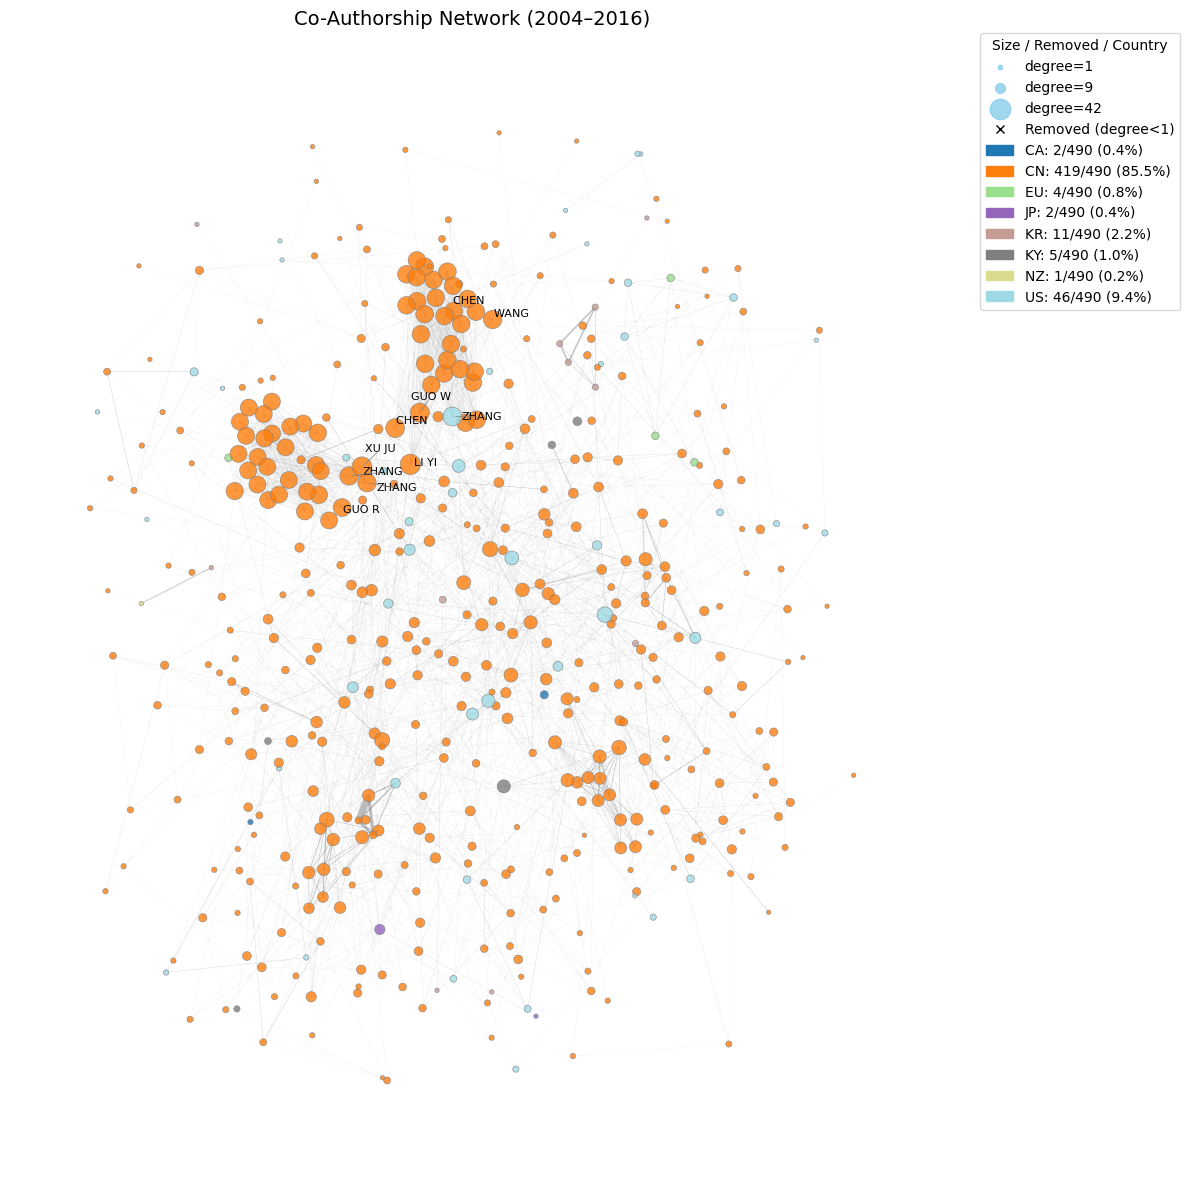

In [30]:
# Cell 8: Co‑Authorship Network visualization — remove nodes with degree < 1, colour by country, limit labels to 5 characters, prevent label overlap, include size/ratio in legend, slight overlap mitigation
import matplotlib.pyplot as plt                 # Import Matplotlib for plotting
import networkx as nx                            # Import NetworkX for graph operations
from adjustText import adjust_text               # Import adjustText to prevent label overlap
import matplotlib.patches as mpatches            # Import patches for legend colour blocks
import matplotlib.lines as mlines                # Import lines for legend symbols

min_degree = 1                                   # Degree threshold (remove nodes with degree < 1)
nodes_kept = [n for n, d in G.degree() if d >= min_degree]  # Select nodes with degree ≥ 1
G2 = G.subgraph(nodes_kept).copy()               # Create subgraph of kept nodes

pos = nx.spring_layout(G2, k=0.2, iterations=20, seed=42)   # Force‑directed layout with increased spacing

deg = dict(G2.degree())                          # Dictionary of node degrees
nodes, degrees = zip(*deg.items())               # Separate node list and degree list
node_sizes = [(d + 1) * 5 for d in degrees]      # Scale node sizes by degree

weights = [G2[u][v]['weight'] for u, v in G2.edges()]  # List of edge weights
widths = [w / max(weights) * 5 for w in weights] if weights else []  # Scale edge widths

# Map each inventor to their country code
nat_map = {
    n: df_expl2.loc[df_expl2['inventor'] == n, 'inventor_nat'].iloc[0]
    for n in nodes
}

# Define EU member codes (excluding GB)
EU_CODES = {
    "AT","BE","BG","HR","CY","CZ","DK","EE","FI","FR","DE","GR",
    "HU","IE","IT","LV","LT","LU","MT","NL","PL","PT","RO","SK","SI","ES","SE"
}

# Group each node as 'GB', 'EU', or other
group_map = {
    n: (
        'GB' if nat_map.get(n) == 'GB' else
        'EU' if nat_map.get(n) in EU_CODES else
        nat_map.get(n, 'UN')
    )
    for n in nodes
}

unique_groups = sorted(set(group_map.values()))   # List of unique groups
cmap = plt.cm.get_cmap('tab20', len(unique_groups))  # Discrete colormap
color_map = {g: cmap(i) for i, g in enumerate(unique_groups)}  # Map groups to colours
node_colors = [color_map[group_map[n]] for n in nodes]  # List of node colours

plt.figure(figsize=(12, 12))
nx.draw_networkx_edges(
    G2, pos,
    width=widths, edge_color='gray', alpha=0.5   # Draw edges
)
nx.draw_networkx_nodes(
    G2, pos,
    nodelist=nodes, node_size=node_sizes,       # Draw nodes with size scaling
    node_color=node_colors, alpha=0.8,           # Draw nodes with colour mapping
    linewidths=0.5, edgecolors='grey'            # Node border settings
)

# Label the top 10 nodes by degree, truncated to 5 characters
top10 = sorted(deg, key=deg.get, reverse=True)[:10]
labels = {n: n[:5] for n in top10}
texts = []
for n, lab in labels.items():
    x, y = pos[n]
    texts.append(plt.text(x, y, lab, fontsize=8))
adjust_text(
    texts,
    expand_points=(1.1, 1.1),                     # Slightly increase spacing
    arrowprops=dict(arrowstyle='-', color='gray', lw=0.5)
)

total_nodes = len(nodes)
avg_deg = int(sum(degrees) / total_nodes)
# Legend handles for node sizes
size_handles = [
    plt.scatter([], [], s=(d + 1) * 5, color='skyblue', alpha=0.8)
    for d in [min(degrees), avg_deg, max(degrees)]
]
size_labels = [f'degree={d}' for d in [min(degrees), avg_deg, max(degrees)]]

# Handle for removed nodes
removed_handle = mlines.Line2D(
    [], [], linestyle='None', marker='x', color='black',
    label=f'Removed (degree<{min_degree})'
)

# Legend handles for country groups
group_counts = {
    g: sum(1 for n in nodes if group_map[n] == g)
    for g in unique_groups
}
group_handles = [
    mpatches.Patch(
        color=color_map[g],
        label=f"{g}: {group_counts[g]}/{total_nodes} ({group_counts[g]/total_nodes:.1%})"
    )
    for g in unique_groups
]

# Combine all legend entries
all_handles = size_handles + [removed_handle] + group_handles
all_labels = size_labels + [removed_handle.get_label()] + [h.get_label() for h in group_handles]
plt.legend(
    all_handles, all_labels,
    title='Size / Removed / Country',
    bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.0
)

plt.axis('off')                                   # Hide axes
plt.title(f'Co-Authorship Network ({min(year_sel)}–{max(year_sel)})', fontsize=14)
plt.tight_layout()
plt.show()


## **9. Network by Country (draft)**

/tmp/ipython-input-31-796713108.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap          = cm.get_cmap('tab20', len(unique_groups))


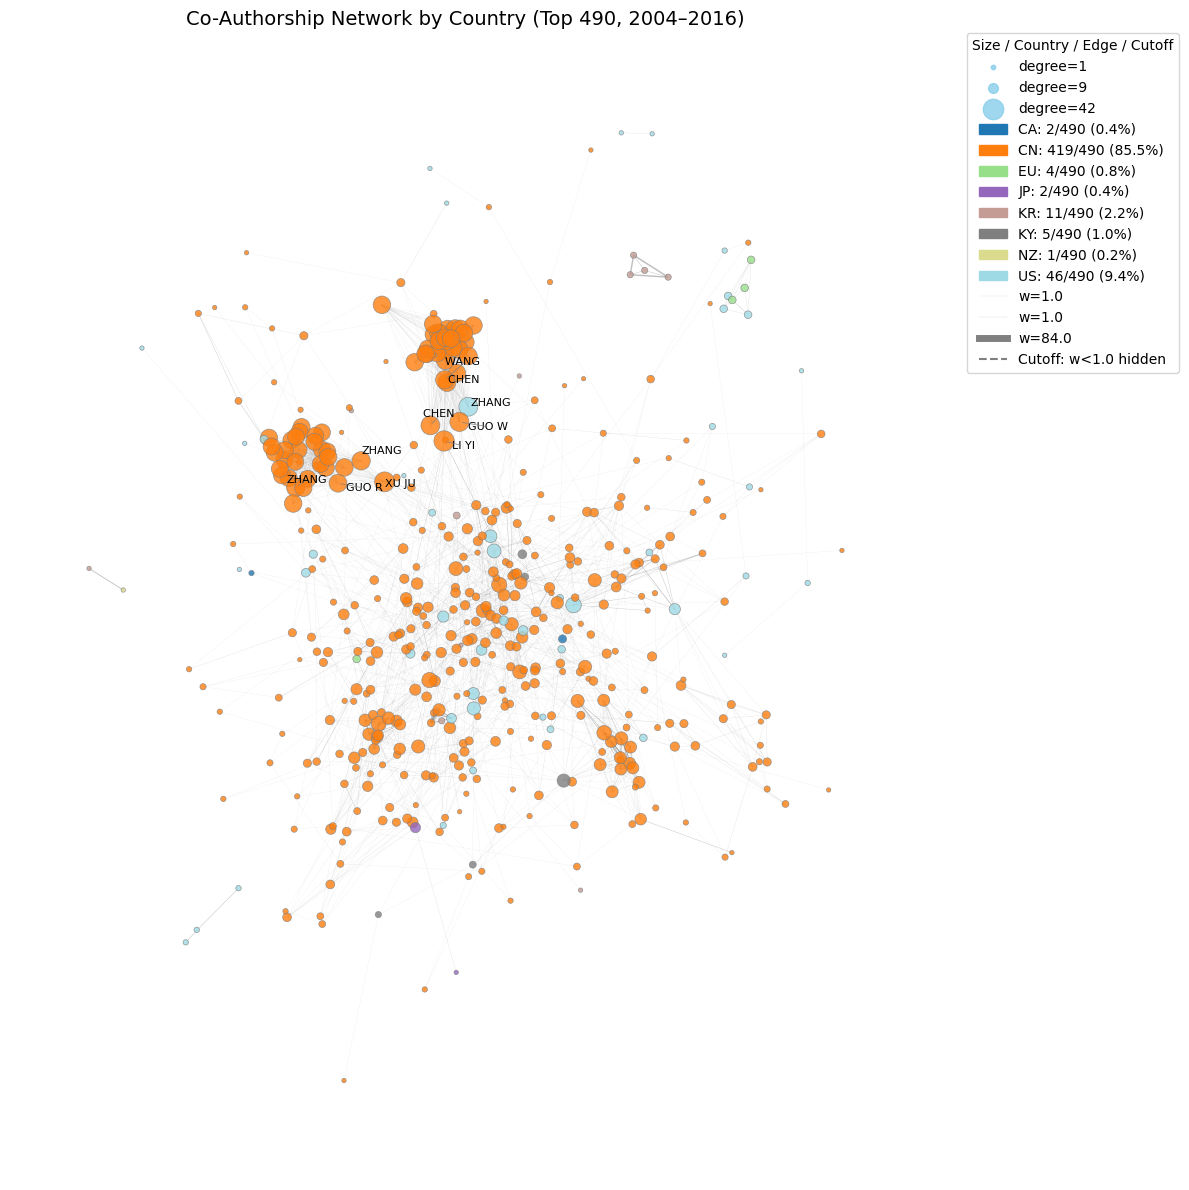

In [31]:
# Cell 9.1: Co-Authorship Network by Country
import matplotlib.pyplot as plt             # Matplotlib for visualization
import networkx as nx                       # NetworkX for graph operations
import matplotlib.cm as cm                  # Colormap module
import matplotlib.patches as mpatches       # Patches for legend colours
import matplotlib.lines as mlines           # Line styles for legend
from adjustText import adjust_text          # To prevent label overlap

# 0) Prepare nodes and edges
min_degree    = 1                                                      # Minimum degree threshold
nodes_kept    = [n for n, d in G.degree() if d >= min_degree]          # Keep nodes with degree ≥ 1
G2            = G.subgraph(nodes_kept).copy()                          # Create subgraph
deg           = dict(G2.degree()); nodes, degrees = zip(*deg.items())  # Degree dictionary and lists
node_sizes    = [(d + 1) * 5 for d in degrees]                         # Scale node sizes by degree

# 1) Map each inventor to their country code
nat_map = {
    n: df_expl2.loc[df_expl2['inventor'] == n, 'inventor_nat'].iloc[0]
    for n in nodes
}

# 2) Define EU group and assign group labels
EU_CODES = {
    "AT","BE","BG","HR","CY","CZ","DK","EE","FI","FR","DE","GR",
    "HU","IE","IT","LV","LT","LU","MT","NL","PL","PT","RO","SK","SI","ES","SE"
}
group_map = {
    n: ('EU' if nat_map[n] in EU_CODES else
        'GB' if nat_map[n] == 'GB' else
        nat_map[n] or 'UN')
    for n in nodes
}

# 3) Assign colours to each group
unique_groups = sorted(set(group_map.values()))
cmap          = cm.get_cmap('tab20', len(unique_groups))
color_map     = {g: cmap(i) for i, g in enumerate(unique_groups)}
node_colors   = [color_map[group_map[n]] for n in nodes]

# 4) Filter edges by weight cutoff
raw_edges      = list(G.edges(data='weight'))
raw_w          = [w for _, _, w in raw_edges]
threshold      = 1.0
filtered_edges = [(u, v) for u, v, w in raw_edges if w >= threshold]
widths         = [w / max(raw_w) * 5 for _, _, w in raw_edges if w >= threshold]

# 5) Adjust layout slightly
pos = nx.spring_layout(G, pos=pos, k=0.1, iterations=5, seed=42)

# 6) Draw edges and nodes
plt.figure(figsize=(12, 12))
nx.draw_networkx_edges(
    G, pos,
    edgelist=filtered_edges, width=widths,
    edge_color='gray', alpha=0.5
)
nx.draw_networkx_nodes(
    G, pos,
    nodelist=nodes, node_size=node_sizes,
    node_color=node_colors, alpha=0.8,
    linewidths=0.5, edgecolors='grey'
)

# 7) Label the top 10 nodes by degree (limit to 5 characters)
top10 = sorted(deg, key=deg.get, reverse=True)[:10]
texts = [plt.text(*pos[n], n[:5], fontsize=8) for n in top10]
adjust_text(
    texts,
    expand_text=(1.5, 1.5), expand_points=(2, 2),
    force_text=(0.5, 0.5), force_points=(0.2, 0.2),
    arrowprops=dict(arrowstyle='-', color='gray', lw=0.5)
)

# 8) Prepare legend entries
total_nodes  = len(nodes)
deg_min, deg_avg, deg_max = min(degrees), int(sum(degrees) / total_nodes), max(degrees)

# 8.1) Node size legend
size_handles = [
    plt.scatter([], [], s=(d + 1) * 5, color='skyblue', alpha=0.8)
    for d in (deg_min, deg_avg, deg_max)
]
size_labels = [f'degree={d}' for d in (deg_min, deg_avg, deg_max)]

# 8.2) Country group legend
group_counts = {g: sum(1 for n in nodes if group_map[n] == g) for g in unique_groups}
group_handles = [
    mpatches.Patch(
        color=color_map[g],
        label=f"{g}: {group_counts[g]}/{total_nodes} ({group_counts[g] / total_nodes:.1%})"
    )
    for g in unique_groups
]

# 8.3) Edge width legend
edge_stats   = [
    (min(raw_w), min(widths)),
    (threshold, sum(widths) / len(widths)),
    (max(raw_w), max(widths))
]
edge_handles = [
    mlines.Line2D([], [], color='gray', lw=scaled, label=f"w={orig:.1f}")
    for orig, scaled in edge_stats
]

# 8.4) Cutoff legend
cut_handle = mlines.Line2D(
    [], [], linestyle='--', color='gray',
    label=f'Cutoff: w<{threshold:.1f} hidden'
)

# Combine all legend handles and labels
all_handles = size_handles + group_handles + edge_handles + [cut_handle]
all_labels  = size_labels + [h.get_label() for h in group_handles] + \
              [h.get_label() for h in edge_handles] + [cut_handle.get_label()]
plt.legend(
    all_handles, all_labels,
    title='Size / Country / Edge / Cutoff',
    bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.
)

# 9) Finalize plot
plt.axis('off')
plt.title(f'Co-Authorship Network by Country (Top {total_nodes}, {min(year_sel)}–{max(year_sel)})', fontsize=14)
plt.tight_layout()
plt.show()


/tmp/ipython-input-32-2211268261.py:58: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap           = cm.get_cmap('tab20', len(unique_groups))


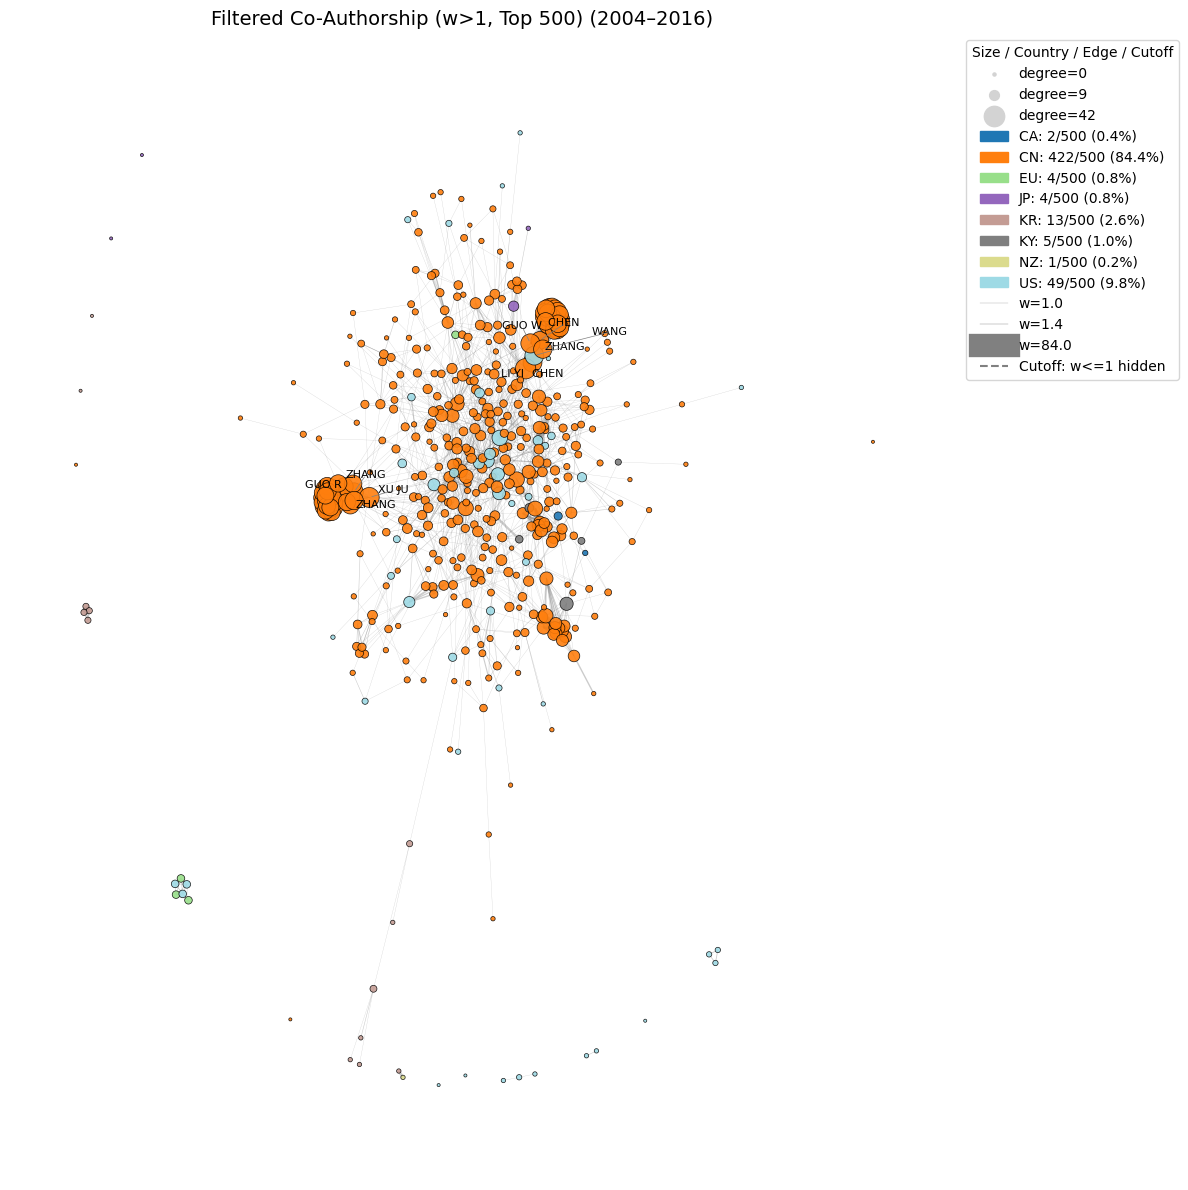

In [32]:
# Cell 9.2: Country-Based Cluster Layout with Overlap Mitigation
import numpy as np                              # Numerical computations
import matplotlib.pyplot as plt                 # Matplotlib for visualization
import matplotlib.cm as cm                      # Colormap module
import matplotlib.patches as mpatches           # Legend colour patches
import matplotlib.lines as mlines               # Legend line styles
import networkx as nx                           # NetworkX for graph operations
from adjustText import adjust_text              # Prevent label overlap

# 0) Remove edges below weight cutoff
edges_to_remove = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] < 1]
G_filtered     = G.copy()
G_filtered.remove_edges_from(edges_to_remove)

# 1) Build subgraph of top 1000 nodes by degree
deg_f         = dict(G_filtered.degree())
top_nodes_f   = sorted(deg_f, key=deg_f.get, reverse=True)[:1000]
G_sub         = G_filtered.subgraph(top_nodes_f).copy()

# 2) Map nodes to country codes and consolidate EU countries
country_map = {
    n: df_expl2.loc[df_expl2['inventor'] == n, 'inventor_nat'].iloc[0]
    for n in G_sub.nodes()
}
EU_CODES    = {
    "AT","BE","BG","HR","CY","CZ","DK","EE","FI","FR","DE","GR",
    "HU","IE","IT","LV","LT","LU","MT","NL","PL","PT","RO","SK","SI","ES","SE"
}
group_map   = {
    n: ('EU' if country_map[n] in EU_CODES else country_map[n] or 'UN')
    for n in G_sub.nodes()
}

# 3) Compute cluster centers on a circle for each group
groups  = sorted(set(group_map.values()))
angles  = np.linspace(0, 2 * np.pi, len(groups), endpoint=False)
centers = {g: np.array([np.cos(a), np.sin(a)]) for g, a in zip(groups, angles)}

# 4) Initialize positions: group center + small random offset
pos_init = {
    n: centers[group_map[n]] + 0.1 * np.random.randn(2)
    for n in G_sub.nodes()
}

# 5) Apply spring layout for better spacing
pos = nx.spring_layout(G_sub, pos=pos_init, k=3.0, iterations=200, seed=42)
pos = {n: coord * 1.5 for n, coord in pos.items()}  # Scale coordinates

# 6) Compute styling parameters
deg_sub        = dict(G_sub.degree())
nodes_sub, degrees_sub = zip(*deg_sub.items())
node_sizes     = [(d + 1) * 5 for d in degrees_sub]
weights_sub    = [d['weight'] for _, _, d in G_sub.edges(data=True)]
widths_sub     = [max(w * 0.2, 0.1) for w in weights_sub]

# 7) Assign colours per group
unique_groups  = sorted(set(group_map.values()))
cmap           = cm.get_cmap('tab20', len(unique_groups))
color_map      = {g: cmap(i) for i, g in enumerate(unique_groups)}
node_colors    = [color_map[group_map[n]] for n in G_sub.nodes()]

# 8) Draw edges and nodes
plt.figure(figsize=(12, 12))
nx.draw_networkx_edges(
    G_sub, pos,
    width=widths_sub, edge_color='gray', alpha=0.4
)
nx.draw_networkx_nodes(
    G_sub, pos,
    node_size=node_sizes, node_color=node_colors,
    alpha=0.9, linewidths=0.5, edgecolors='black'
)

# 9) Label the top 10 nodes (truncate to 5 characters)
top10_sub = sorted(deg_sub, key=deg_sub.get, reverse=True)[:10]
texts     = [plt.text(*pos[n], n[:5], fontsize=8) for n in top10_sub]
adjust_text(
    texts,
    expand_text=(1.5, 1.5), expand_points=(2, 2),
    force_text=(0.5, 0.5), force_points=(0.2, 0.2),
    arrowprops=dict(arrowstyle='-', color='gray', lw=0.5),
    lim=1000
)

# 10) Prepare legend entries
total_nodes = len(nodes_sub)
deg_vals    = [min(degrees_sub), int(sum(degrees_sub) / total_nodes), max(degrees_sub)]

# 10.1) Node size legend
size_handles = [
    plt.scatter([], [], s=(d + 1) * 5, color='lightgray', label=f'degree={d}')
    for d in deg_vals
]

# 10.2) Group colour legend
group_counts = {g: sum(1 for n in nodes_sub if group_map[n] == g) for g in unique_groups}
color_handles = [
    mpatches.Patch(color=color_map[g],
                   label=f"{g}: {group_counts[g]}/{total_nodes} ({group_counts[g]/total_nodes:.1%})")
    for g in unique_groups
]

# 10.3) Edge width legend
link_vals    = [min(weights_sub), sum(weights_sub) / len(weights_sub), max(weights_sub)]
link_handles = [
    mlines.Line2D([], [], color='gray', linewidth=max(w * 0.2, 0.1), label=f"w={w:.1f}")
    for w in link_vals
]

# 10.4) Cutoff legend
cut_handle = mlines.Line2D([], [], linestyle='--', color='gray', label='Cutoff: w<=1 hidden')

plt.legend(
    handles=size_handles + color_handles + link_handles + [cut_handle],
    title='Size / Country / Edge / Cutoff',
    bbox_to_anchor=(1.05, 1), loc='upper left'
)

# 11) Final touches
plt.axis('off')
plt.title(
    f'Filtered Co-Authorship (w>1, Top {total_nodes}) ({min(year_sel)}–{max(year_sel)})',
    fontsize=14
)
plt.tight_layout()
plt.show()

## **10. Patent Count by Year and PTO Type**

In [33]:
# Cell 10: Patent Count by Year and PTO Type
import pandas as pd    # pandas for data handling
import os              # os for file path operations

# 1) Remove duplicates based on year, PTO_type, appl_id
df_type = (
    df_expl2[['year', 'PTO_type', 'appl_id']]
      .drop_duplicates()  # Remove duplicate (year, PTO_type, appl_id) rows
)

# 2) Aggregate counts
patent_counts_by_type = (
    df_type
      .groupby(['year', 'PTO_type'])    # Group by year and PTO_type
      .size()                           # Count patents
      .reset_index(name='patent_count')
      .pivot(
          index='year',
          columns='PTO_type',
          values='patent_count'
      )
      .fillna(0).astype(int)            # Replace NaN with 0 and convert to int
)

# 3) Add Total row
total_row = patent_counts_by_type.sum(axis=0)  # Sum across years for each PTO_type
total_row.name = 'Total'                       # Name the summary row
patent_counts_by_type = pd.concat([
    patent_counts_by_type,
    pd.DataFrame([total_row])
])

# 4) Save to CSV
out_path = os.path.join(base_dir, 'patent_by_PTO_type.csv')
patent_counts_by_type.to_csv(out_path, index=True)  # Include index (years and Total)


In [34]:
patent_counts_by_type

PTO_type     CN    EP   JP    KR     US
2000          0     1    0     0      2
2001          0     1    0     0      2
2002          0     0    0     0     20
2003          0     0    0     0     41
2004          0     0    0     0     92
2005         63    66    0     8    207
2006        144   140    2    39    289
2007        170   161    3    39    370
2008        226   232    4    43    365
2009        289   199    3    74    387
2010        369   241    4   101    504
2011        548   265    4   104    577
2012        804   302    4    85    670
2013       1175   322   13   124    853
2014       1381   403   11   153   1017
2015       1679   350    7   156   1139
2016       1803   347   14   164   1244
2017       2128   307   14   273   1397
2018       2811   277   10   248   1496
2019       3253   157    9   259   1501
2020       3247    84   14   255   1210
2021       3012    35    4   190    683
2022       1905     5    4    78    257
2023        835     0    0    30     29
Total     25842  3895  124  2423  14352

## **11. Patent Count by Year and Country Group**

In [35]:
# Cell 11: Patent Count by Year and Country Group
import numpy as np      # NumPy for numerical operations
import pandas as pd     # pandas for data manipulation
import os               # os for file path operations

# 1) Create country_code and country_group
df_country = df_expl2.copy()

# Extract first two letters of applicant_nat, convert to uppercase
df_country['country_code'] = (
    df_country['applicant_nat']
      .fillna('')              # Replace NaN with empty string
      .astype(str)             # Convert to string
      .str[:2]                 # Take first two characters
      .str.upper()             # Convert to uppercase
)

# Define EU member codes (excluding GB)
EU_CODES = {
    "AT","BE","BG","HR","CY","CZ","DK","EE","FI","FR","DE","GR",
    "HU","IE","IT","LV","LT","LU","MT","NL","PL","PT","RO","SK","SI","ES","SE"
}

# Group EU countries under 'EU', keep others as their code
df_country['country_group'] = np.where(
    df_country['country_code'].isin(EU_CODES),
    'EU',
    df_country['country_code']
)

# 2) Remove duplicates by (year, country_group, appl_id)
df_country = (
    df_country[['year', 'country_group', 'appl_id']]
      .drop_duplicates()
)

# 3) Aggregate patent counts by year and country_group, then pivot
patent_counts_by_country = (
    df_country
      .groupby(['year', 'country_group'])
      .size()                          # Count patents
      .reset_index(name='patent_count')
      .pivot(
          index='year',
          columns='country_group',
          values='patent_count'
      )
      .fillna(0)                       # Replace NaN with zero
      .astype(int)                     # Convert counts to integer
)

# 4) Add Total row summing across all years
total_row = patent_counts_by_country.sum(axis=0)
total_row.name = 'Total'
patent_counts_by_country = pd.concat([
    patent_counts_by_country,
    pd.DataFrame([total_row], index=['Total'])
])

# 5) Save results to CSV
out_path2 = os.path.join(
    base_dir,
    'patent_counts_by_country_by_year.csv'
)
patent_counts_by_country.to_csv(out_path2, index=True)  # Include year and Total in index


In [36]:
patent_counts_by_country

country_group         AE  AN  AR   AU  BB  BM  BR  BS  ...  TH  TR   TW  UA  \
2000           0   0   0   0   0    0   0   0   0   0  ...   0   0    0   0   
2001           0   0   0   0   0    0   0   0   0   0  ...   0   0    0   0   
2002           0   0   0   0   0    0   0   0   0   0  ...   0   0    0   0   
2003           0   0   0   3   0    0   0   0   0   0  ...   0   0    0   0   
2004           0   0   0   0   0    1   0   0   0   0  ...   0   0    1   0   
2005           0   0   0   0   0    3   0   0   0   0  ...   0   0    3   0   
2006           0   0   1   1   0    1   0   0   0   0  ...   0   0    6   0   
2007           1   1   0   1   0    2   0   0   1   0  ...   0   0    7   0   
2008           0   0   0   2   0    7   0   0   0   0  ...   0   0    7   0   
2009           0   0   0   0   0    6   0   1   0   0  ...   0   0   14   0   
2010           0   0   0   0   0    7   3   0   0   0  ...   0   0   19   0   
2011           0   0   0   2   0    6   1   0   1   0  ...   0   0    9   0   
2012           0   1   0   3   0   11   3   0   1   0  ...   0   1   16   0   
2013           0   0   0   0   1   21   3   2   1   0  ...   0   1   25   0   
2014           0   1   0   0   0   16   3   1   5   0  ...   0   2   31   0   
2015           0   0   2   0   0   10   2   1   0   1  ...   0   0   34   0   
2016           0   1   0   0   0   12   6   0   3   1  ...   2   0   25   0   
2017           0   2   2   0   0   17   0   0   3   0  ...   0   3   31   0   
2018           0   0   0   0   0   21   1   0   3   0  ...   0   4   27   0   
2019           0   0   0   0   0    5   0   0   0   0  ...   0   1   31   1   
2020           0   1   0   0   0    4   1   0   1   0  ...   0   0   24   0   
2021           0   2   0   0   0    2   0   0   0   0  ...   1   0   19   0   
2022           0   2   1   0   0    2   0   0   0   0  ...   0   0    6   0   
2023           0   0   0   0   0    0   0   0   0   0  ...   0   0    0   0   
Total          1  11   6  12   1  154  23   5  19   2  ...   3  12  335   1   

country_group     US  UY  VG  VN  WS  ZA  
2000               1   0   0   0   0   0  
2001               2   0   0   0   0   0  
2002              19   0   0   0   0   0  
2003              28   0   0   0   0   0  
2004              65   0   0   0   0   0  
2005             177   0   0   0   0   0  
2006             250   0   0   0   0   0  
2007             321   0   1   0   0   0  
2008             411   0   1   0   0   0  
2009             393   0   1   0   0   1  
2010             431   0   0   0   0   0  
2011             562   0   1   1   0   0  
2012             619   0   0   0   0   1  
2013             732   1   1   0   1   0  
2014             874   0   4   0   0   2  
2015             909   0   4   0   0   1  
2016            1027   0   2   0   0   0  
2017            1130   0   2   0   0   0  
2018            1156   0   2   0   0   0  
2019            1108   0   1   0   0   0  
2020             877   0   0   0   0   0  
2021             488   0   0   1   0   0  
2022             171   0   0   0   0   0  
2023              17   0   0   0   0   0  
Total          11768   1  20   2   1   5  

[25 rows x 52 columns]

In [37]:
# df_expl2 중간 확인
display(
    df_expl2[
        ['appl_id','year', 'PTO_type', 'applicant', 'applicant_main_code',  'applicant_nat','country_code','inventor','num_inventors','inventor_nat', 'title', 'abstract', 'claim_main']
    ]
    # .sort_values(by='applicant', ascending=False)
    .head(1)
)


appl_id  year PTO_type applicant applicant_main_code applicant_nat  \
0  16/887692  2020       US       IBM            UN000019            US   

  country_code            inventor  num_inventors inventor_nat  \
0           US  MALETSABISA MOLAPO            4.0           ZA   

                                               title  \
0  Contextual safety assessment, recommendations,...   

                                            abstract  \
0  Method and systems for identifying dangers in ...   

                                          claim_main  
0  1. A method to identify dangers in an accessib...

In [38]:
# 1) appl_id 기준으로 중복 제거, 첫 번째 행 유지
df_expl2 = df_expl2.drop_duplicates(subset=['appl_id'], keep='first')

# 2) 중간 확인
display(
    df_expl2[
        ['appl_id','year','PTO_type','applicant','applicant_main_code',
         'applicant_nat','country_code','inventor','num_inventors',
         'inventor_nat','title','abstract','claim_main']
    ]
    # .sort_values(by='applicant', ascending=False)
    .head(1)
)


appl_id  year PTO_type applicant applicant_main_code applicant_nat  \
0  16/887692  2020       US       IBM            UN000019            US   

  country_code            inventor  num_inventors inventor_nat  \
0           US  MALETSABISA MOLAPO            4.0           ZA   

                                               title  \
0  Contextual safety assessment, recommendations,...   

                                            abstract  \
0  Method and systems for identifying dangers in ...   

                                          claim_main  
0  1. A method to identify dangers in an accessib...

In [39]:
df_expl2.shape

(46636, 50)

In [40]:
df_expl2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46636 entries, 0 to 46738
Data columns (total 50 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   PTO_id                 46636 non-null  object        
 1   PTO_type               46636 non-null  object        
 2   patent_kind            46636 non-null  object        
 3   pub_type_code          46636 non-null  object        
 4   title                  46636 non-null  object        
 5   title_en               44213 non-null  object        
 6   abstract               46614 non-null  object        
 7   abstract_en            44186 non-null  object        
 8   claim_main             46636 non-null  object        
 9   claim_main_en          44212 non-null  object        
 10  claims_indep           46636 non-null  object        
 11  claims_indep_en        44211 non-null  object        
 12  num_claims             46636 non-null  int64         
 13  appl_i

## **12-(1): Environment setup and compatible version installation**

In [41]:
# Pipeline: PatentSBERTa‑Based Patent Text Classification and Retrieval (Lightweight & High‑Speed)
# Objective: Replace full BERT fine‑tuning with (1) embeddings + lightweight classifier or (2) optional LoRA fine‑tuning to accelerate processing

# Structure:
# Cell 1: Environment setup and package installation
# Cell 2: Library imports and basic configuration
# Cell 3: Data loading (e.g. CSV) and preprocessing
# Cell 4: Train/validation split
# Cell 5: Load PatentSBERTa embedding model
# Cell 6: Generate embeddings (with caching support)
# Cell 7: Train lightweight classifier (LogisticRegression)
# Cell 8: Evaluation (classification report and confusion matrix)
# Cell 9: Save artifacts (embedding model, classifier, label encoder)
# Cell 10: Load and inference functions
# Cell 11: Batch/stream processing utilities
# Cell 12 (optional): LoRA fine‑tuning (execute only if needed)
# Cell 13 (optional): LoRA model evaluation and saving


In [42]:
# Cell 12-(1): Environment setup and compatible version installation

# 0) Remove conflicting installations
!pip uninstall -y torch torchvision torchaudio fastai pillow 2>/dev/null || true

# 1) Install required libraries (torch 2.6.0 + cu124, torchvision 0.21.0 + cu124)
!pip install -U pip
!pip install --index-url https://download.pytorch.org/whl/cu124 \
    torch==2.6.0+cu124 torchvision==0.21.0+cu124 torchaudio==2.6.0

# 2) Install remaining packages
!pip install -q sentence-transformers>=2.7.0 scikit-learn pandas numpy fastai==2.7.19

# 3) (optional) Disable vision submodule to prevent transformers from loading it
import os
os.environ["TRANSFORMERS_NO_TORCHVISION"] = "1"
os.environ["DISABLE_TRANSFORMERS_AV"]   = "1"

# 4) Verify installations
import torch
import torchvision
import PIL

print("Torch        :", torch.__version__)
print("Torchvision  :", torchvision.__version__)
print("Pillow       :", PIL.__version__)
try:
    import fastai
    print("FastAI       :", fastai.__version__)
except ImportError:
    print("FastAI not installed")


Found existing installation: torch 2.6.0+cu124
Uninstalling torch-2.6.0+cu124:
  Successfully uninstalled torch-2.6.0+cu124
Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124
Found existing installation: torchaudio 2.6.0+cu124
Uninstalling torchaudio-2.6.0+cu124:
  Successfully uninstalled torchaudio-2.6.0+cu124
Found existing installation: fastai 2.7.19
Uninstalling fastai-2.7.19:
  Successfully uninstalled fastai-2.7.19
Found existing installation: pillow 11.3.0
Uninstalling pillow-11.3.0:
  Successfully uninstalled pillow-11.3.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 36.5 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
Looking in indexes: https://download.pytorch.org/whl/cu124
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 187.5 MB/s eta 0:00:00
     ━━━

## **12‑(2): Library Import & Device Check**

In [43]:
# Cell 12‑(2): Imports and Global Configuration
import os, re                                                        # OS and regular expressions
import numpy as np                                                   # Numerical computations
import pandas as pd                                                  # DataFrame operations
from sklearn.model_selection import train_test_split                 # Train/test splitting

# Columns to combine: title (발명의 명칭 / Invention title), abstract (요약 / Abstract), claim_main (대표청구항 / Main claim)
TEXT_COLS = ["title", "abstract", "claim_main"]

# Use GPU if available
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)                                             # Display chosen device


Device: cuda


In [44]:
# df_expl2를 복사하여 df_expl3 생성
# 원본 보존용 복제본 생성
df_expl3 = df_expl2.copy()


In [45]:
df_expl3.shape

(46636, 50)

In [46]:
df_expl3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46636 entries, 0 to 46738
Data columns (total 50 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   PTO_id                 46636 non-null  object        
 1   PTO_type               46636 non-null  object        
 2   patent_kind            46636 non-null  object        
 3   pub_type_code          46636 non-null  object        
 4   title                  46636 non-null  object        
 5   title_en               44213 non-null  object        
 6   abstract               46614 non-null  object        
 7   abstract_en            44186 non-null  object        
 8   claim_main             46636 non-null  object        
 9   claim_main_en          44212 non-null  object        
 10  claims_indep           46636 non-null  object        
 11  claims_indep_en        44211 non-null  object        
 12  num_claims             46636 non-null  int64         
 13  appl_i

In [47]:
# 방법 1: 전체 중복된 행 수 (첫 번째 이후 중복 건수)
dup_count = df_expl3['appl_id'].duplicated().sum()
print(f"중복된 appl_id 행 수: {dup_count}")

# 방법 2: 각 appl_id별 빈도 집계 후, 2회 이상 등장한 모든 건수 합산
vc = df_expl3['appl_id'].value_counts()           # appl_id별 출현 횟수 계산
dup_total = vc[vc > 1].sum()                      # 2회 이상인 횟수들만 합산
print(f"중복된 appl_id 총 출현 수: {dup_total}")

# 방법 3: 유니크한 중복 appl_id 개수
unique_dup_ids = (vc > 1).sum()                   # 2회 이상 등장하는 appl_id 개수
print(f"중복된 고유 appl_id 개수: {unique_dup_ids}")


중복된 appl_id 행 수: 0
중복된 appl_id 총 출현 수: 0
중복된 고유 appl_id 개수: 0


## **12-(3): Generate Fulltext and Seed Labels**

In [48]:
## ==============================================
# 셀 12-(3): fulltext 생성 및 Seed LLM 라벨 생성 (확장 + 한국어 상세 주석 강화)
# ==============================================
# 목적:
#  - 특허/문헌 텍스트에서 LLM/Transformer 관련 기술·모델·방법론 언급 여부를 1/0 라벨로 부여
#  - 다국어(한/중/일) 및 최신 한국/중국/글로벌 모델명 포함
#  - 구조적(카테고리별) 키워드 관리 → 유지보수 용이
#  - False Positive(일반 단어와 충돌) 최소화를 위한 후처리 옵션 제공

# 전제:
#  - TEXT_COLS: 결합할 텍스트 컬럼 리스트 (이미 상위 셀에서 정의되어 있다고 가정)
#  - df_expl3: 라벨을 부여할 DataFrame
#  - fulltext 컬럼이 없으면 생성, 있으면 재사용

def combine_text(r):
    """
    행(row)의 TEXT_COLS 내 텍스트를 결합하여 fulltext 문자열 생성.
    - None/빈 문자열/비문자 타입(예: float, int)은 제외
    - 줄바꿈 전/후 공백 제거
    - 구분은 " \n " (줄 단위로 결합) → 추후 문장 분해/패턴 매칭 시 가독성 유지
    """
    return " \n ".join([
        str(r[c]).strip()
        for c in TEXT_COLS
        if c in r and isinstance(r[c], str) and r[c].strip()
    ])

# fulltext 컬럼이 없을 경우에만 생성 (이미 전처리에서 만든 경우 중복 연산 회피)
if "fulltext" not in df_expl3.columns:
    df_expl3["fulltext"] = df_expl3.apply(combine_text, axis=1)

import re

# ==============================================
# (A) 카테고리별 키워드 정의
#  - 각 리스트는 해당 주제/범주에 속하는 정규식 패턴 문자열
#  - 패턴 작성 원칙:
#     * 소문자/대문자 구분 제거: re.IGNORECASE 사용
#     * 변형/숫자/Parameter size(7B, 13B 등)는 (?:[-\s]?[0-9]+[bBkK]?)? 로 포괄
#     * 하이픈/공백 모두 허용: [-\s]? 또는 [-\s]?복합 사용
#     * 과매칭 위험(일반 단어) → 후처리(filter_false_positives)에서 문맥 검사
#  - 필요 시 특정 카테고리를 제외하면 즉시 정규식 범위 축소 가능
# ==============================================

# -------- core_models : 모델명(브랜드/패밀리) --------
# --------------------------------------------------------
# core_models : 전세계 + 중국 + 한국 LLM 고유명사/브랜드/대표 패밀리
# - 목적: 텍스트 안에 특정 모델 언급(특허/논문/기사) 탐지
# - 포함: 상용(Claude, Gemini), 오픈소스(LLaMA, Mistral), 연구(BLOOM, Chinchilla), 중국(Qwen, DeepSeek, KIMI, ChatGLM 등), 한국(HyperCLOVA, EXAONE, SOLAR, Midm 등)
# - 주의: 일반 단어와 충돌 가능 (claude, ernie, solar 등) → 후처리 필터 권장
# --------------------------------------------------------
# 주의: 'claude', 'ernie', 'solar' 는 일반 단어/인명과 충돌 가능
core_models = [
    # 글로벌 / 오픈 / 상용
    r'large language model', r'LLM', r'neural language model(?:s)?',
    r'foundation model', r'chatgpt', r'gpt[-\s]?[0-9]+(?:\.[0-9])?',
    r'bert(?:-\w+)?', r'roberta', r't5', r'longt5', r'xlnet', r'albert', r'distilbert',
    r'ul2', r'falcon', r'mistral', r'mixtral', r'gemma', r'orca',
    r'phi[-\s]?[0-9]+', r'openelm', r'vicuna', r'guanaco',
    # LLaMA 계열
    r'llama(?:[-\s]?(?:[0-9]+[bBkK]?|2|3))?', r'codellama', r'openllama',
    # 주요 상용/대형
    r'claude(?:[-\s]?[0-9]+)?',          # FP 가능 (인명) → 후처리
    r'gemini(?:[-\s]?(?:pro|ultra|flash)?)?',
    r'palm[-\s]?2', r'palm2',
    r'opt(?:[-\s]?[0-9]+[bBkK]?)?', r'gopher', r'chinchilla',
    r'megatron[-\s]?turing(?:[-\s]?nlg)?', r'mt[-\s]?nlg', r'megatron',
    r'gpt[-\s]?neox(?:[-\s]?[0-9]+[bBkK]?)?', r'gpt[-\s]?neo(?:[-\s]?[0-9]+[bBkK]?)?',
    r'gpt[-\s]?j(?:[-\s]?[0-9]+[bBkK]?)?',
    # 커뮤니티 / 오픈
    r'bloomz?(?:[-\s]?[0-9]+[bBkK]?)?', r'jurassic(?:[-\s]?(?:1|2|jr))?',
    r'mpt(?:[-\s]?[0-9]+[bBkK]?)?', r'pythia(?:[-\s]?[0-9]+[bBkK]?)?',
    r'dolly(?:[-\s]?[0-9]+[bBkK]?)?', r'stablelm(?:[-\s]?[0-9]+[bBkK]?)?',
    r'rwkv(?:[-\s]?[0-9]+[bBkK]?)?', r'starcoder(?:[-\s]?[0-9]+[bBkK]?)?',
    r'codegen(?:[-\s]?[0-9]+[bBkK]?)?', r'codet5(?:[-\s]?[0-9]+[bBkK]?)?',
    r'wizardlm(?:[-\s]?[0-9]+[bBkK]?)?', r'wizardcoder(?:[-\s]?[0-9]+[bBkK]?)?',
    r'zephyr(?:[-\s]?[0-9]+[bBkK]?)?', r'phi(?:[-\s]?[0-9]+[bBkK]?)?',
    r'medalpaca', r'finet5', r'biogpt', r'chemberta',
    r'CodeBERT', r'BioBERT', r'clinicalbert',
    # 중국
    r'ernie', r'wenxin', r'ernie bot', r'qwen(?:[-\s]?[0-9]+[bBkK]?)?',
    r'deepseek(?:[-\s]?[0-9]+[bBkK]?)?', r'yi(?:[-\s]?[0-9]+[bBkK]?)?',
    r'baichuan(?:[-\s]?[0-9]+[bBkK]?)?', r'chatglm(?:[-\s]?[0-9]+)?',
    r'internlm(?:[-\s]?[0-9]+[bBkK]?)?', r'pangu(?:[-\s]?[0-9]+[bBkK]?)?',
    r'sparkdesk', r'sensechat', r'kimi(?:[-\s]?chat)?', r'abab(?:[-\s]?[\w]+)?',
    r'ziya', r'm6', r'aquila(?:[-\s]?[\w]+)?',
    # 한국
    r'hyperc[lL]ova(?:[-\s]?(?:x|2|[0-9]+[bBkK]?))?', r'kogpt(?:[-\s]?[0-9]+[bBkK]?)?',
    r'polyglot(?:[-\s]?ko)?(?:[-\s]?[0-9]+[bBkK]?)?', r'koalpaca',
    r'clovax', r'클로바엑스', r'solar(?:[-\s]?[0-9]+[bBkK]?)?', r'솔라',
    r'exaone(?:[-\s]?(?:2|2\.0|[0-9]+[bBkK]?))?', r'엑사원',
    r'kullm(?:[-\s]?[0-9]+[bBkK]?)?', r'kovicuna', r'코비쿠나',
    r'kolama', r'kollama', r'korwkv', r'kollm', r'kocoder',
    r'korean[-\s]?stablelm', r'korealm', r'하이퍼클로바', r'한국어\s?LLM'
]

# -------- 아키텍처 변형 / 구조적 확장 --------
# model_variants_arch : 아키텍처 확장/변형 (희소, 확장, 특수구조)
# - 목적: 구조적 혁신(Perceiver, Mixture-of-Experts, State Space 등) 탐지
# - FP 낮음 (대부분 전문 용어)
# --------------------------------------------------------
model_variants_arch = [
    r'transformer[-\s]?(?:based|encoder|decoder)?', r'encoder[-\s]?decoder',
    r'sequence-to-sequence', r'esm(?:[-\s]?[0-9]+)?',
    r'mixture[-\s]?of[-\s]?experts', r'MoE', r'sparsely[-\s]?gated mixture[-\s]?of[-\s]?experts',
    r'Switch[-\s]?Transformer', r'GShard', r'stacked mixture[-\s]?of[-\s]?experts',
    r'sparse transformer', r'perceiver(?:[-\s]?IO)?', r'transformer[-\s]?xl',
    r'hierarchical transformer', r'dynamic convolution', r'conformer',
    r'hypernetwork', r'graph transformer', r'state space model', r'Mamba'
]

# -------- 어텐션 / 포지셔널 / 컨텍스트 --------
# attention_positional : 어텐션 및 위치/컨텍스트 처리 기법
# - 목적: 효율/성능/긴문맥 관련 메커니즘 추출
# - 활용: 모델 성능·추론최적화 연구 태깅
# --------------------------------------------------------
attention_positional = [
    r'self[-\s]?attention', r'multi[-\s]?head attention', r'attention mechanism',
    r'sparse attention', r'global attention', r'local attention', r'axial attention',
    r'linear attention', r'flash attention', r'scaled dot[-\s]?product attention',
    r'cross[-\s]?attention', r'memory attention', r'rotary positional embedding', r'RoPE',
    r'ALiBi', r'relative positional encoding', r'absolute positional encoding',
    r'sinusoidal positional encoding', r'position[-\s]?wise feed[-\s]?forward',
    r'kv[-\s]?cache', r'windowed attention', r'blockwise attention'
]

# -------- 파라미터 효율 / PEFT --------
# parameter_efficiency : 파라미터 효율 미세조정(PEFT) 기법
# - 목적: 비용 절감·경량화 기법 탐지
# - 분석 포인트: 모델 재사용성, 적은 데이터 적응
# --------------------------------------------------------
parameter_efficiency = [
    r'parameter[-\s]?efficient fine[-\s]?tuning', r'PEFT', r'LoRA', r'QLoRA',
    r'adapter(?:s)?', r'adapter[-\s]?layer', r'prefix[-\s]?tuning', r'prompt[-\s]?tuning',
    r'soft prompt(?:ing)?', r'p[-\s]?tuning', r'bitfit', r'low[-\s]?rank adaptation',
    r'sparse fine[-\s]?tuning', r'lightweight fine[-\s]?tuning', r'hypernetwork adaptation',
    r'lora[-\s]?merged', r'training head', r'partial fine[-\s]?tuning'
]

# -------- 학습 패러다임 / 정렬 / 목적 --------
# training_paradigms : 학습 목적·전략·튜닝 프로세스
# - 목적: 사전학습 목적 / 튜닝 종류 / 정렬 학습 방식 태깅
# - DPO, RLAIF 등 최신 preference 최적화 포함
# --------------------------------------------------------
training_paradigms = [
    r'pretraining', r'pre[-\s]?training', r'masked language model(?:s)?',
    r'autoregressive model(?:s)?', r'denoising objective', r'causal language modeling',
    r'span corruption', r'instruction[-\s]?tuning', r'supervised fine[-\s]?tuning',
    r'SFT', r'alignment tuning', r'contrastive learning', r'multi[-\s]?task learning',
    r'domain adaptation', r'curriculum learning', r'continual learning',
    r'reinforcement learning from human feedback', r'RLHF',
    r'RLAIF', r'DPO', r'direct preference optimization',
    r'offline reinforcement learning', r'self[-\s]?distillation', r'knowledge distillation'
]

# -------- 프롬프트 / 추론 / Reasoning --------
# prompting_inference : 프롬프트 설계·추론 강화·Reasoning 전략
# - 목적: CoT, ReAct, Tree-of-Thought 등 추론 향상 패턴 탐지
# - 활용: reasoning 성능 비교, 기법 빈도 분석
# --------------------------------------------------------
prompting_inference = [
    r'prompt[-\s]?engineering', r'prompt[-\s]?tuning', r'prompt design',
    r'few[-\s]?shot (?:learning|inference)', r'one[-\s]?shot learning', r'zero[-\s]?shot learning',
    r'chain[-\s]?of[-\s]?thought', r'CoT', r'self[-\s]?consistency',
    r'tree[-\s]?of[-\s]?thought', r'graph[-\s]?of[-\s]?thought', r'deliberate reasoning',
    r'scratchpad', r'react framework', r'REACT', r'function calling', r'tool use',
    r'planning prompting', r'reflection prompting', r'progressive hinting',
    r'role prompting', r'instruction following', r'reasoning step'
]

# -------- 검색 / 메모리 / RAG --------
# retrieval_memory : 검색·외부지식 결합·메모리 확장
# - 목적: RAG 기반 파이프라인/컨텍스트 관리 전략 탐지
# - 활용: LLM+지식그래프/DB 통합 연구 분류
# --------------------------------------------------------
retrieval_memory = [
    r'retrieval[-\s]?augmented generation', r'RAG', r'knowledge grounding',
    r'vector store', r'faiss index', r'elastic vector search', r'semantic cache',
    r'external memory', r'memory transformer', r'episodic memory', r'kNN[-\s]?LM',
    r'retrieval head', r'hybrid retrieval', r'context window extension', r'chunking strategy',
    r'context compression', r'document augmentation', r'oracle retrieval'
]

# -------- 정렬 / 안전 / 윤리 --------
# alignment_safety : 가치정렬·안전성·오용 방지
# - 목적: RLHF/안전필터/레드팀 등 정책·제어 관련 용어 탐지
# - 활용: RAI 전략 비교, 규제·거버넌스 근거 도출
# --------------------------------------------------------
alignment_safety = [
    r'value alignment', r'model alignment', r'safety alignment', r'alignment tax',
    r'harmlessness', r'hallucination reduction', r'mitigat(?:e|ion) bias',
    r'red teaming', r'safety filter', r'content moderation', r'toxicity detection',
    r'safety policy', r'responsible AI', r'harm minimization', r'refusal policy',
    r'ethical guardrail', r'over[-\s]?refusal', r'jailbreak defense'
]

# -------- 다국어 / 교차언어 --------
# multilingual_crosslingual : 다국어/교차언어 적응
# - 목적: 번역·교차 전이·언어 내재화 전략 탐지
# - 활용: 다언어 성능/데이터 편향 분석
# --------------------------------------------------------
multilingual_crosslingual = [
    r'multilingual model', r'cross[-\s]?lingual transfer', r'code[-\s]?switching',
    r'language adaptation', r'multilingual embedding', r'cross[-\s]?lingual alignment',
    r'bilingual lexicon induction', r'machine translation'
]

# -------- 태스크 / 응용 --------
# tasks_applications : 적용 태스크/도메인 활용
# - 목적: LLM 활용 영역 분포(요약/QA/코드 등) 측정
# - 참고: 과매칭 우려 낮으나 범용 단어 등장 가능 (필요 시 필터)
# --------------------------------------------------------
tasks_applications = [
    r'text generation', r'text summarization', r'machine translation',
    r'question answering', r'natural language understanding',
    r'language understanding', r'language generation', r'semantic parsing',
    r'dialogue generation', r'conversation agent', r'conversational AI',
    r'information extraction', r'entity recognition', r'slot filling',
    r'sentiment analysis', r'code generation', r'program synthesis'
]

# -------- 최적화 / 효율 / 병렬 --------
# optimization_efficiency : 학습/추론 효율·병렬·압축
# - 목적: 비용 절감/성능-자원 최적화 기술 태깅
# - 활용: 인프라 전략·운영 효율 연구
# --------------------------------------------------------
optimization_efficiency = [
    r'gradient checkpointing', r'mixed precision training', r'fp16', r'bf16',
    r'quantization', r'8[-\s]?bit quantization', r'4[-\s]?bit quantization',
    r'int8 inference', r'weight pruning', r'sparsification', r'kv cache reuse',
    r'pipeline parallel(?:ism)?', r'tensor parallel(?:ism)?', r'data parallel(?:ism)?',
    r'megatron', r'deepseed', r'zero redundancy optimizer', r'ZeRO',
    r'activation offloading', r'flash inference', r'graph optimisation',
    r'operator fusion', r'compilation caching'
]

# -------- 표현 / 임베딩 / 토크나이징 --------
# representation_embeddings : 임베딩·토크나이징·표현학습
# - 목적: 입력 전처리/표현 품질 개선 기법 탐지
# - 활용: 서브워드 전략·문맥 임베딩 진화 분석
# --------------------------------------------------------
representation_embeddings = [
    r'contextual (?:embedding|representation)', r'word embedding',
    r'vector embedding', r'sentence embedding', r'document embedding',
    r'tokenization', r'subword tokenization', r'byte[-\s]?pair encoding', r'BPE',
    r'wordpiece', r'unigram language model tokenization', r'sentencepiece',
    r'morpheme segmentation', r'multivector embedding'
]

# -------- 평가 / 벤치마크 / 지표 --------
# evaluation_benchmark : 평가/벤치마크/지표
# - 목적: 모델 성능 비교에 사용되는 데이터셋·지표 탐지
# - FP 가능: 'perplexity' 일반적 언급, 필요시 제외
# --------------------------------------------------------
evaluation_benchmark = [
    r'perplexity', r'benchmark suite', r'few[-\s]?shot benchmark', r'mmlu',
    r'hellaswag', r'arc[-\s]?challenge', r'BIG[-\s]?bench', r'winogrande',
    r'truthfulqa', r'bbh', r'codeeval', r'leaderboard evaluation', r'human eval'
]

# -------- 디코딩 / 출력 제어 --------
# misc_components : 디코딩·출력 제어·추론 설정
# - 목적: 생성 품질/다양성/안정성 조정 기법 탐지
# --------------------------------------------------------
misc_components = [
    r'decoder[-\s]?only model', r'causal decoder', r'beam search',
    r'top[-\s]?k sampling', r'top[-\s]?p sampling', r'nucleus sampling',
    r'temperature scaling', r'repetition penalty', r'length penalty',
    r'stop sequence', r'streaming generation', r'context window',
    r'sliding window decoding'
]

# -------- 비영문(한·중·일) 핵심 용어 --------
# local_lang_terms : 다국어(한/중/일) LLM 핵심 용어
# - 목적: 비영문 코퍼스에서 LLM 관련 문맥 탐지
# - 주의: 일부 일반적(언어 모델) → 과매칭 시 제거 고려
# --------------------------------------------------------
#  * '언어 모델' 과매칭 많으면 제거 고려
local_lang_terms = [
    # 한국어
    r'대규모 언어 모델', r'언어 모델', r'사전 학습 언어 모델',
    r'프롬프트 엔지니어링', r'프롬프트 튜닝', r'체인 오브 생각',
    # 중국어
    r'大规模语言模型', r'语言模型', r'预训练语言模型',
    r'提示工程', r'提示调优', r'链式思维',
    # 일본어
    r'大規模言語モデル', r'言語モデル', r'事前学習言語モデル',
    r'プロンプトエンジニアリング', r'プロンプトチューニング', r'思考の連鎖'
]

# (B) 카테고리 사전
LLM_KEYWORD_CATEGORIES = {
    "core_models": core_models,
    "model_variants_arch": model_variants_arch,
    "attention_positional": attention_positional,
    "parameter_efficiency": parameter_efficiency,
    "training_paradigms": training_paradigms,
    "prompting_inference": prompting_inference,
    "retrieval_memory": retrieval_memory,
    "alignment_safety": alignment_safety,
    "multilingual_crosslingual": multilingual_crosslingual,
    "tasks_applications": tasks_applications,
    "optimization_efficiency": optimization_efficiency,
    "representation_embeddings": representation_embeddings,
    "evaluation_benchmark": evaluation_benchmark,
    "misc_components": misc_components,
    "local_lang_terms": local_lang_terms
}

# (C) 전체 패턴 병합
#  - set으로 중복 제거 → 길이 내림차순 정렬(긴 패턴 우선 매칭 → 과도한 부분매칭 감소)
all_keywords = set()
for lst in LLM_KEYWORD_CATEGORIES.values():
    all_keywords.update(lst)

sorted_keywords = sorted(all_keywords, key=len, reverse=True)

# \b 경계: 영문 토큰 기준. 한중일 문자열에는 크게 문제 없지만
#  - 더 정밀 필요 시 (?<!\w) ... (?!\w) 사용 고려
LLM_PATTERN = re.compile(r'\b(' + "|".join(sorted_keywords) + r')\b', re.IGNORECASE)

# (D) False Positive 후처리
def filter_false_positives(matches, text, window=50):
    """
    FP 최소화 룰 기반 필터:
    - claude: Anthropic 모델 언급 아니면 제거
    - ernie : 'bot','wenxin','baidu','llm' 인접 없으면 제거
    - solar : 일반 'solar panel' 혼동 방지 위해 'llm','model','upstage' 체크
    window: 양 옆 문맥 길이(문자 수)
    """
    lt = text.lower()
    filtered = []
    for m in matches:
        token = m.lower()
        idx = lt.find(token)
        ctx = lt[max(0, idx - window): idx + len(token) + window]
        keep = True
        if token.startswith('claude') and not any(k in ctx for k in ['anthropic', 'model', 'ai', 'llm']):
            keep = False
        if token == 'ernie' and not any(k in ctx for k in ['bot', 'wenxin', 'baidu', 'llm']):
            keep = False
        if token.startswith('solar') and not any(k in ctx for k in ['llm', 'model', 'upstage']):
            keep = False
        if keep:
            filtered.append(m)
    return filtered

# (E) Seed 라벨 함수
def seed_label(txt):
    """
    개별 문서/텍스트에 대해:
      1) 문자열 아니면 0
      2) 정규식 매칭 → 후보 목록
      3) FP 후처리 적용
      4) 남은 매칭 존재 시 1, 없으면 0
    고급 확장:
      - 매칭 토큰/카테고리 리스트를 별도 컬럼(df_expl3['llm_hits'])로 저장 가능
      - 카테고리 빈도 분석 추가 가능
    """
    if not isinstance(txt, str):
        return 0
    raw_matches = re.findall(LLM_PATTERN, txt)
    if not raw_matches:
        return 0
    filtered = filter_false_positives(raw_matches, txt)
    return 1 if filtered else 0

# (F) 라벨 생성
df_expl3["seed_llm_label"] = df_expl3["fulltext"].apply(seed_label)
df_expl3["final_label"] = df_expl3["seed_llm_label"]

# (G) 라벨 분포 출력 (품질 점검: 비율이 너무 높거나 낮으면 패턴/FP 필터 조정)
print("Seed label distribution:\n", df_expl3["final_label"].value_counts())


Seed label distribution:
 final_label
0    39025
1     7611
Name: count, dtype: int64


In [49]:
# 2) DataFrame을 Drive 경로에 저장
output_path = "/content/drive/MyDrive/data1/df_expl3_keyword_extraction.csv"

# (필요하다면 폴더를 미리 생성)
import os
os.makedirs(os.path.dirname(output_path), exist_ok=True)

# 3) CSV로 저장
df_expl3.to_csv(output_path, index=False, encoding="utf-8-sig")
print(f"Saved classified data to {output_path}")


Saved classified data to /content/drive/MyDrive/data1/df_expl3_keyword_extraction.csv


In [50]:
# df_expl3 기본/변수별 기술통계 확인
df_expl3["seed_llm_label"].value_counts()                              # 행·열 개수 확인

seed_llm_label
0    39025
1     7611
Name: count, dtype: int64

In [51]:
#df_expl3.info()                              # 열별 데이터 타입·non-null 개수 확인

In [52]:
df_expl3['country_code'].describe()          # country_code 기초통계

count     46636
unique       76
top          CN
freq      23942
Name: country_code, dtype: object

In [53]:
# 범주형 변수 분포 확인
df_expl3['country_code'].value_counts()      # country_code 카테고리별 빈도

country_code
CN    23942
US    11768
KR     2991
JP     2119
IT      734
      ...  
IS        1
JM        1
KN        1
BG        1
AR        1
Name: count, Length: 76, dtype: int64

In [54]:
# 두 변수 동시 통계
df_expl3[['final_label','country_code']].describe(include='all')
# └ include='all' 지정 시 범주형 변수도 요약

final_label country_code
count   46636.000000        46636
unique           NaN           76
top              NaN           CN
freq             NaN        23942
mean        0.163200          NaN
std         0.369552          NaN
min         0.000000          NaN
25%         0.000000          NaN
50%         0.000000          NaN
75%         0.000000          NaN
max         1.000000          NaN

## **12-(4): Train/Validation Split**

In [55]:
# Cell 12-(4): Train/Validation Split (Stratified, Memory/Speed Optimized)
# 0) Extract minimal required columns and drop missing values (minimize deep copies)
#  subset of columns ['fulltext' (전체텍스트), 'final_label' (최종라벨)]
subset = df_expl3.loc[:, ["fulltext", "final_label"]].dropna()
# Convert final_label to 'category' dtype for reduced memory and easier code handling
if subset["final_label"].dtype != "category":
    subset["final_label"] = subset["final_label"].astype("category")

# 1) Option: Use index-based splitting for very long texts to reduce memory copy
use_index_split = True  # Set to False for simpler but more memory-intensive split

t0 = time.time()  # Start timer

if use_index_split:
    idx = subset.index.to_numpy()                          # Get index array
    y_codes = subset["final_label"].cat.codes.to_numpy()  # Label codes array (integers for stratify)
    train_idx, valid_idx = train_test_split(
        idx,
        test_size=0.1,
        random_state=42,
        stratify=y_codes
    )
    # Create train and valid DataFrames from indices, reset indices
    train_df = subset.loc[train_idx].reset_index(drop=True)
    valid_df = subset.loc[valid_idx].reset_index(drop=True)
else:
    # Simpler split directly on DataFrame (use if memory allows)
    train_df, valid_df = train_test_split(
        subset,
        test_size=0.1,
        random_state=42,
        stratify=subset["final_label"]
    )
    train_df = train_df.reset_index(drop=True)
    valid_df = valid_df.reset_index(drop=True)

elapsed = time.time() - t0  # Elapsed time

In [56]:
print(f"Train size: {len(train_df)}  Valid size: {len(valid_df)}  (elapsed {elapsed:.3f}s)")
print("Class distribution (train):")
print(train_df["final_label"].value_counts(normalize=True).round(3))
print("Class distribution (valid):")
print(valid_df["final_label"].value_counts(normalize=True).round(3))

# 2) (Optional) Cache saving for faster reloads
# train_df.to_feather("train_df.feather")   # Fast storage with Feather format
# valid_df.to_feather("valid_df.feather")


Train size: 41972  Valid size: 4664  (elapsed 0.028s)
Class distribution (train):
final_label
0    0.837
1    0.163
Name: proportion, dtype: float64
Class distribution (valid):
final_label
0    0.837
1    0.163
Name: proportion, dtype: float64


## **12-(5): Load PatentSBERTa Model**

In [57]:
# Cell 12-(5): Load PatentSBERTa Model for Embedding Extraction
import os # Check file existence / create directories
import numpy as np # Array saving/loading and numerical operations
from sentence_transformers import SentenceTransformer  # Pre‑trained Sentence‑BERT loader
import time # Measure elapsed time
# SentenceBERT (Reimers & Gurevych, 2019))
# PatentSBERTa (Bekamiri et al., 2024)
# MODEL_NAME = "AI-Growth-Lab/PatentSBERTa"  # Define model
MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"  # Lightweight, fast SBERT model name
sbert = SentenceTransformer(MODEL_NAME, device=DEVICE)  # Load device
device = "cuda" if hasattr(__import__("torch"), "cuda") and __import__("torch").cuda.is_available() else "cpu"  # Determine if GPU is available
sbert.max_seq_length = 256  # Reduce maximum token length (improves speed, lowers memory)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [58]:
# Cell 2: Check Embedding Dimension
# Get and display the dimensionality of the sentence/document embeddings produced by the model
print("Embedding dimension:", sbert.get_sentence_embedding_dimension())

Embedding dimension: 384


In [59]:
# Cell 3: Check Maximum Sequence Length
# Retrieve and display the maximum number of tokens the tokenizer/model can handle in one pass
print("Max sequence length:", sbert.get_max_seq_length())

Max sequence length: 256


In [60]:
# Cell 4: Inspect Pooling Configuration
# Access the Pooling module to see which pooling modes are enabled
from sentence_transformers import models
pooling = next(m for m in sbert._modules.values() if isinstance(m, models.Pooling))
print("Mean pooling enabled:", pooling.pooling_mode_mean_tokens)
print("CLS pooling enabled:", pooling.pooling_mode_cls_token)
print("Max pooling enabled:", pooling.pooling_mode_max_tokens)

Mean pooling enabled: True
CLS pooling enabled: False
Max pooling enabled: False


In [61]:
# Cell 5: Inspect Transformer Backbone Configuration
# Access the Transformer module's config to view hidden size, number of layers, attention heads, etc.
transformer = next(m for m in sbert._modules.values() if isinstance(m, models.Transformer))
cfg = transformer.auto_model.config
print("Hidden size:", cfg.hidden_size)
print("Number of layers:", cfg.num_hidden_layers)
print("Number of attention heads:", cfg.num_attention_heads)
print("Vocabulary size:", cfg.vocab_size)
print("Max position embeddings:", cfg.max_position_embeddings)

Hidden size: 384
Number of layers: 6
Number of attention heads: 12
Vocabulary size: 30522
Max position embeddings: 512


## **12-(6): Optimising SBERT Embedding Pipeline**

In [62]:
# Cell 12-(6): Caching and Optimised SBERT Embedding Extraction Pipeline
# 1) Configure cache directory -------------------------------------------------------------
CACHE_DIR = "emb_cache"                       # Folder to store embedding cache
os.makedirs(CACHE_DIR, exist_ok=True)         # Create folder if it does not exist

# 2) Prepare input text and label arrays (avoid unnecessary .tolist()) ---------------------
train_texts = train_df["fulltext"].values     # Training texts (NumPy view)
valid_texts = valid_df["fulltext"].values     # Validation texts (NumPy view)
y_train = train_df["final_label"].values      # Training labels
y_valid = valid_df["final_label"].values      # Validation labels

# 3) Define cache file paths ----------------------------------------------------------------
train_cache = os.path.join(CACHE_DIR, "X_train_minilm.npz")  # Path for training embedding cache
valid_cache = os.path.join(CACHE_DIR, "X_valid_minilm.npz")  # Path for validation embedding cache

# 4) Define embedding computation function --------------------------------------------------
def encode_texts(text_array, batch_size=128, normalize=True):  # Convert text array to embeddings
    return sbert.encode(
        text_array,                      # Input text array
        batch_size=batch_size,           # Batch size (recommend 128–256 for GPU)
        show_progress_bar=False,         # Disable progress bar to reduce overhead
        convert_to_numpy=True,           # Return as NumPy array
        normalize_embeddings=normalize   # Apply L2 normalisation for cosine similarity
    )

# 5) Load from cache or compute embeddings -------------------------------------------------
t0 = time.time()                                    # Start timing
if os.path.exists(train_cache) and os.path.exists(valid_cache):  # If both cache files exist
    X_train = np.load(train_cache)["arr_0"]          # Load training embeddings
    X_valid = np.load(valid_cache)["arr_0"]          # Load validation embeddings
    cache_status = "loaded from cache"               # Status label
else:
    X_train = encode_texts(train_texts, batch_size=128, normalize=True)  # Compute training embeddings
    X_valid = encode_texts(valid_texts, batch_size=128, normalize=True)  # Compute validation embeddings
    np.savez_compressed(train_cache, X_train)        # Save compressed training embeddings
    np.savez_compressed(valid_cache, X_valid)        # Save compressed validation embeddings
    cache_status = "computed & cached"               # Status label

elapsed = time.time() - t0                           # Calculate elapsed time

In [63]:
# 6) Output results ------------------------------------------------------------------------
print(f"[{cache_status}] elapsed: {elapsed:.2f}s")    # Print cache/computation status and time taken
print("Train embedding shape:", X_train.shape)        # Print training embedding dimensions
print("Valid embedding shape:", X_valid.shape)        # Print validation embedding dimensions
print("Label sample (train):", np.unique(y_train)[:5])# Show a few unique training labels

# 7) (Optional) Additional optimisation tips ------------------------------------------------
# - For faster prototyping: set sbert.max_seq_length = 192 (may incur slight accuracy loss)
# - For very large corpora: use memory‑mapping (np.memmap) to avoid loading all data into memory at once
# - If normalize_embeddings=False, apply faiss.normalize_L2(X_train) afterwards for cosine normalisation
# - Alternative lightweight model: "sentence-transformers/all-MiniLM-L12-v2" (slightly more accurate, a bit slower)

# 8) (Optional) Free memory ----------------------------------------------------------------
# del train_texts, valid_texts  # Uncomment to release arrays when no longer needed

[computed & cached] elapsed: 73.15s
Train embedding shape: (41972, 384)
Valid embedding shape: (4664, 384)
Label sample (train): [0 1]


## **12-(7): Train Logistic Regression Classifier**

In [64]:
# Cell 12-(7): Train Logistic Regression Baseline Classifier

from sklearn.linear_model import LogisticRegression # Import logistic regression model
from sklearn.metrics import accuracy_score, f1_score, classification_report  # Import evaluation metrics
import time # Import time module for timing

# 1) Re‑encode train and validation texts (avoid overwriting X_all)
X_train = encode_texts(train_df["fulltext"].values, batch_size=128)  # Compute embeddings for training texts
X_valid = encode_texts(valid_df["fulltext"].values, batch_size=128)  # Compute embeddings for validation texts

# 2) Verify array dimensions
print(f"X_train shape: {X_train.shape}, y_train length: {len(y_train)}")
print(f"X_valid shape: {X_valid.shape}, y_valid length: {len(y_valid)}")

# 3) Define the logistic regression model
log_clf = LogisticRegression(
    max_iter=500,            # Maximum number of iterations
    class_weight="balanced", # Adjust weights inversely proportional to class frequencies
    solver="lbfgs",          # Use the LBFGS optimisation algorithm
    n_jobs=-1                # Utilise all available CPU cores
)

# 4) Train the model and measure duration
t0 = time.time()
log_clf.fit(X_train, y_train)   # Fit the model on the training data
print(f"Training elapsed: {time.time() - t0:.2f}s")  # Print training duration

# 5) Perform predictions
valid_pred  = log_clf.predict(X_valid)             # Predict class labels for validation set
valid_proba = log_clf.predict_proba(X_valid)[:, 1] # Extract probability of the positive class (e.g. LLM)

# 6) Display performance metrics
print("LogReg Accuracy:", accuracy_score(y_valid, valid_pred))
print("LogReg F1 (macro):", f1_score(y_valid, valid_pred, average="macro"))
print(classification_report(y_valid, valid_pred))


X_train shape: (41972, 384), y_train length: 41972
X_valid shape: (4664, 384), y_valid length: 4664
Training elapsed: 2.24s
LogReg Accuracy: 0.8421955403087479
LogReg F1 (macro): 0.7661214981288107
              precision    recall  f1-score   support

           0       0.96      0.84      0.90      3903
           1       0.51      0.83      0.63       761

    accuracy                           0.84      4664
   macro avg       0.74      0.84      0.77      4664
weighted avg       0.89      0.84      0.86      4664



- Precision (Class1 = 0.51): Class 1로 예측한 것 중 49%는 잘못된 FP. Class 0을 Class 1로 혼동하는 False Positive(FP)가 많음
- Recall (Class1 = 0.83): Class 1 실제 사례 대부분을 잡아냄 (FN 낮음). threshold 상대적으로 낮음 -> 조금만 Class 1 징후가 있어도 1로 분류
- F1 (Class1 = 0.63): Class 1 종합 성능이 전체 Macro F1를 끌어내림

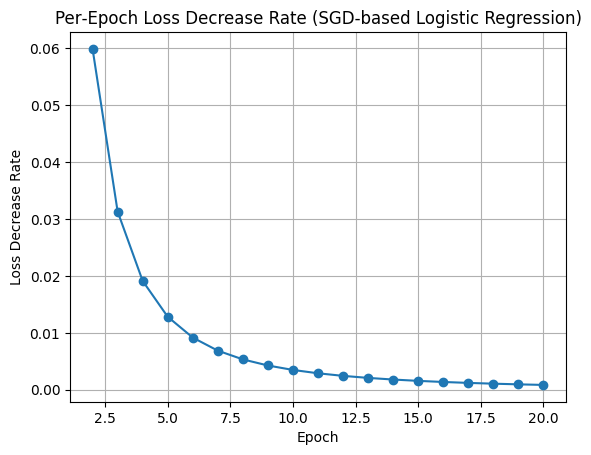

In [65]:
# Cell 12-(7-2): Per‑Epoch Loss Decrease Rate Visualization
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss

# Re-define encode_texts for this cell
def encode_texts(text_array, batch_size=128, normalize=True):
    return sbert.encode(
        text_array,
        batch_size=batch_size,
        show_progress_bar=False,
        convert_to_numpy=True,
        normalize_embeddings=normalize
    )

# Recompute embeddings and labels
X_train = encode_texts(train_df["fulltext"].values, batch_size=128)
y_train = train_df["final_label"].values

# Initialize SGDClassifier for logistic regression approximation
clf = SGDClassifier(
    loss='log_loss',
    learning_rate='constant',
    eta0=0.01,
    max_iter=1,
    tol=None,
    warm_start=True,
    random_state=42
)

# Record log loss over epochs
epochs = 20
losses = []
for epoch in range(epochs):
    clf.fit(X_train, y_train)
    proba = clf.predict_proba(X_train)[:, 1]
    losses.append(log_loss(y_train, proba))

# Compute per‑epoch loss decrease rate: (prev_loss - curr_loss) / prev_loss
decrease_rates = [
    (losses[i-1] - losses[i]) / losses[i-1]
    for i in range(1, len(losses))
]

# Plot loss decrease rate
plt.figure()
plt.plot(range(2, epochs+1), decrease_rates, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss Decrease Rate")
plt.title("Per‑Epoch Loss Decrease Rate (SGD-based Logistic Regression)")
plt.grid(True)
plt.show()


## **12-(8): MLP Classifier with Fixed Embeddings**

In [66]:
# Cell 12-(8): (Optional) Simple MLP Classifier with Fixed Embeddings
USE_MLP = True   # Toggle to enable or disable the MLP

if USE_MLP:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from sklearn.metrics import f1_score, accuracy_score

    torch.manual_seed(42)
    in_dim = X_train.shape[1]  # Input feature dimension

    class MLPClassifier(nn.Module):
        """Simple two‑layer MLP classifier."""
        def __init__(self, in_dim, hidden=256, drop=0.2):
            super().__init__()
            self.net = nn.Sequential(
                nn.Linear(in_dim, hidden),  # Input to hidden layer
                nn.ReLU(),                   # Activation
                nn.Dropout(drop),            # Dropout for regularisation
                nn.Linear(hidden, 2)         # Hidden to output layer (2 classes)
            )
        def forward(self, x):
            return self.net(x)

    # Instantiate model and move to device
    mlp = MLPClassifier(in_dim).to(DEVICE)

    # Convert NumPy embeddings and labels to PyTorch tensors
    Xtr_t = torch.tensor(X_train, dtype=torch.float32).to(DEVICE)
    ytr_t = torch.tensor(y_train, dtype=torch.long).to(DEVICE)
    Xva_t = torch.tensor(X_valid, dtype=torch.float32).to(DEVICE)
    yva_t = torch.tensor(y_valid, dtype=torch.long).to(DEVICE)

    # Compute class weights to address imbalance
    pos = (y_train == 1).sum()
    neg = (y_train == 0).sum()
    w_pos = neg / (pos + 1e-9)
    w_neg = 1.0
    weight_t = torch.tensor([w_neg, w_pos], dtype=torch.float32).to(DEVICE)

    criterion = nn.CrossEntropyLoss(weight=weight_t)  # Weighted cross‑entropy loss
    optimizer = optim.AdamW(mlp.parameters(), lr=2e-4)  # Optimiser
    epochs = 8  # Number of training epochs

    # Training loop
    for ep in range(1, epochs + 1):
        mlp.train()
        logits = mlp(Xtr_t)
        loss = criterion(logits, ytr_t)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Validation evaluation
        mlp.eval()
        with torch.no_grad():
            val_logits = mlp(Xva_t)
            val_pred = val_logits.argmax(dim=1).cpu().numpy()
            val_f1 = f1_score(y_valid, val_pred, average="macro")
        print(f"[MLP Epoch {ep}] loss={loss.item():.4f} val_f1={val_f1:.4f}")

    # Final performance comparison
    with torch.no_grad():
        mlp_val_prob = torch.softmax(val_logits, dim=1)[:, 1].cpu().numpy()
    print("MLP Accuracy:", accuracy_score(y_valid, val_pred))
    print("MLP F1 (macro):", f1_score(y_valid, val_pred, average="macro"))
else:
    mlp = None  # If not used, set to None


[MLP Epoch 1] loss=0.6932 val_f1=0.1403
[MLP Epoch 2] loss=0.6916 val_f1=0.1403
[MLP Epoch 3] loss=0.6898 val_f1=0.1403
[MLP Epoch 4] loss=0.6882 val_f1=0.1403
[MLP Epoch 5] loss=0.6864 val_f1=0.1403
[MLP Epoch 6] loss=0.6847 val_f1=0.1403
[MLP Epoch 7] loss=0.6830 val_f1=0.1420
[MLP Epoch 8] loss=0.6813 val_f1=0.1564
MLP Accuracy: 0.17560034305317324
MLP F1 (macro): 0.15643520223050464


## **12-(9): Generate Embeddings for the Complete df_expl3 Dataset**

In [67]:
# Cell 12-(9): Generate Embeddings for the Complete df_expl3 Dataset
all_texts = df_expl3["fulltext"].tolist()
# Produce embeddings: SBERT -> Tokenization -> Transformer -> Pooling
X_all = encode_texts(all_texts, batch_size=64)
print("All embedding shape:", X_all.shape)

All embedding shape: (46636, 384)


In [68]:
# (616, 384): 616개 문서 × 384차원 임베딩

In [69]:
# ──────────── 셀 12-(9-1): X_all 랜덤 샘플 5개 확인 ────────────

# 재현 가능한 샘플링을 위해 시드 설정
np.random.seed(42)

# 전체 임베딩 개수 중 5개 인덱스를 랜덤 추출
sample_indices = np.random.choice(len(X_all), size=5, replace=False)

for idx in sample_indices:
    patent_id = df_expl3.iloc[idx]['appl_id']          # 해당 행의 특허 ID
    vector    = X_all[idx]                             # 임베딩 벡터
    print(f"Index: {idx}, appl_id: {patent_id}")
    print(f"Embedding shape: {vector.shape}")
    print(vector)                                      # 벡터 요소 출력
    print("-" * 80)


Index: 35216, appl_id: 2020-10675605
Embedding shape: (384,)
[-8.96443054e-02  6.98643625e-02  1.14821389e-01 -8.47836211e-03
 -1.46071017e-01 -6.24910258e-02 -2.08707768e-02  1.16955258e-01
 -2.16149203e-02 -4.66650352e-02 -2.07783729e-02  9.66260792e-04
  5.70970885e-02 -5.44739841e-03 -6.16702810e-02 -5.83393797e-02
 -7.22614154e-02  1.12693787e-01 -3.39042721e-03 -4.23953868e-02
  2.77125053e-02 -6.53514639e-02 -3.59404720e-02 -2.79298238e-02
  3.16514410e-02  4.59773950e-02  2.02041417e-02  8.29472952e-03
  1.31480142e-01 -1.46875344e-03  1.31997187e-02  3.02670114e-02
 -3.06752361e-02 -3.24136093e-02 -5.85634150e-02  9.75591168e-02
 -1.90138873e-02  7.23146871e-02 -1.47399018e-02  1.89374704e-02
  1.26718199e-02 -7.95465149e-03  5.75682446e-02  1.94067322e-02
  4.55267243e-02  1.57214515e-02  3.48084196e-02 -2.91914493e-02
 -9.18459222e-02 -2.63765473e-02 -2.92921104e-02 -2.33707540e-02
 -6.21544980e-02 -4.87992540e-03 -5.77295944e-03  3.40852030e-02
 -6.47199282e-04  1.59562528e

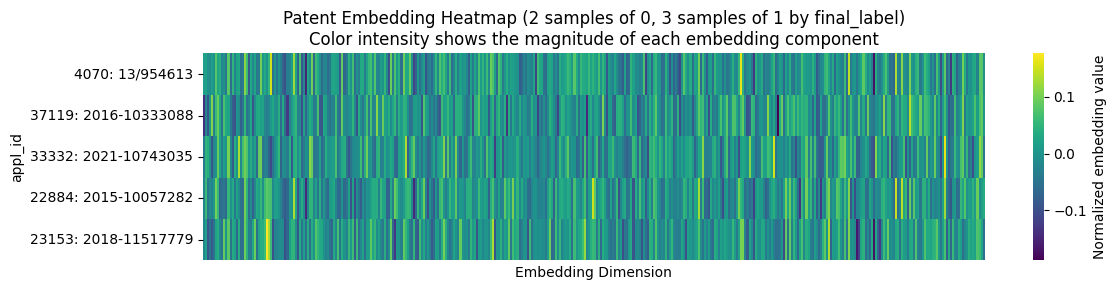

In [70]:
# ──────────── 셀 12-(9-2) 업데이트: Color bar에 값 의미 표시 ────────────
# reproducible RNG
rng = np.random.default_rng(42)

# 1) get indices for each label
idx0 = df_expl3.index[df_expl3["final_label"] == 0].to_numpy()
idx1 = df_expl3.index[df_expl3["final_label"] == 1].to_numpy()

# 2) sample 2 from label 0 and 3 from label 1
sel0 = rng.choice(idx0, size=2, replace=False)
sel1 = rng.choice(idx1, size=3, replace=False)
selected = np.concatenate([sel0, sel1])

# 3) extract embeddings and prepare y‑axis labels
sample_vectors = X_all[selected]  # shape = (5, embedding_dim)
yticks_labels = [
    f"{int(idx)}: {df_expl3.loc[idx, 'appl_id']}"
    for idx in selected
]

# 4) plot heatmap with colorbar label
plt.figure(figsize=(12, 3))
ax = sns.heatmap(
    sample_vectors,
    cmap="viridis",
    cbar=True,
    cbar_kws={'label': 'Normalized embedding value'},  # colorbar label added
    xticklabels=False,
    yticklabels=yticks_labels
)
ax.set_xlabel("Embedding Dimension")
ax.set_ylabel("appl_id")
ax.set_title("Patent Embedding Heatmap (2 samples of 0, 3 samples of 1 by final_label)\n"
             "Color intensity shows the magnitude of each embedding component")
plt.tight_layout()
plt.show()


In [71]:
# ──────────── 셀 12-(9-3): Cosine Similarity Matrix for Selected Samples ────────────

# assume `sample_vectors` and `selected` index list are defined from previous cell
# sample_vectors.shape == (5, embedding_dim)

# 1) Compute cosine similarity matrix
sim_matrix = cosine_similarity(sample_vectors)

# 2) Prepare labels for rows/columns: "index: appl_id"
labels = [f"{idx}: {df_expl3.iloc[idx]['appl_id']}" for idx in selected]

# 3) Build DataFrame for easy visualization
sim_df = pd.DataFrame(sim_matrix, index=labels, columns=labels)

# 4) Display the similarity matrix
display(sim_df)


4070: 12/564546  37119: 2014-10696038  \
4070: 12/564546              1.000000              0.248606   
37119: 2014-10696038         0.248606              1.000000   
33332: 2019-80034903         0.184851              0.305358   
22884: 2020-10854637         0.582685              0.273098   
23153: 2016-11139530         0.485102              0.225930   

                      33332: 2019-80034903  22884: 2020-10854637  \
4070: 12/564546                   0.184851              0.582685   
37119: 2014-10696038              0.305358              0.273098   
33332: 2019-80034903              1.000000              0.117379   
22884: 2020-10854637              0.117379              1.000000   
23153: 2016-11139530              0.127760              0.391999   

                      23153: 2016-11139530  
4070: 12/564546                   0.485102  
37119: 2014-10696038              0.225930  
33332: 2019-80034903              0.127760  
22884: 2020-10854637              0.391999  
23153: 2016-11139530              1.000000

In [72]:
# t‑SNE projection
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_all)


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


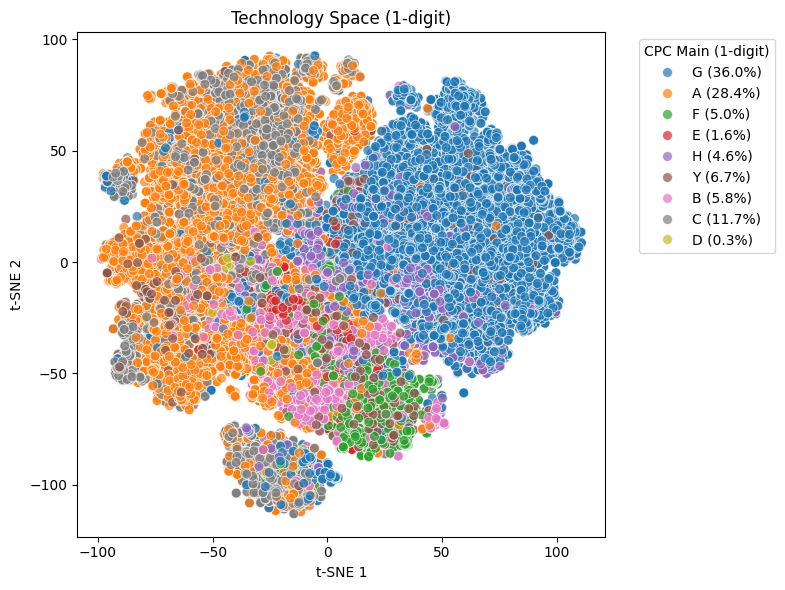

In [73]:
# Cell 12-(9-5): t-SNE by CPC Main 1-digit with Ratios (Unknown & 'n' Excluded)
# Prepare cpc_main1
df_expl3["cpc_main1"] = df_expl3["cpc_main"].astype(str).str[:1]
mask1 = (df_expl3["cpc_main"] != "Unknown") & (df_expl3["cpc_main1"] != "n")
# Filter and assemble
vis1 = pd.DataFrame({
    "tSNE1":     X_tsne[mask1, 0],
    "tSNE2":     X_tsne[mask1, 1],
    "cpc_main1": df_expl3.loc[mask1, "cpc_main1"].values
})
# Compute ratios
counts = vis1["cpc_main1"].value_counts().sort_index()
ratios = (counts / len(vis1) * 100).round(1).astype(str) + "%"

plt.figure(figsize=(8,6))
ax = sns.scatterplot(data=vis1, x="tSNE1", y="tSNE2",
                     hue="cpc_main1", palette="tab10",
                     alpha=0.7, s=50, edgecolor="white")
handles, labels = ax.get_legend_handles_labels()
new_labels = [f"{lab} ({ratios[lab]})" for lab in labels]
ax.legend(handles, new_labels, title="CPC Main (1-digit)",
          bbox_to_anchor=(1.05,1), loc="upper left")
plt.title("Technology Space (1-digit)")
plt.xlabel("t‑SNE 1"); plt.ylabel("t‑SNE 2")
plt.tight_layout()
plt.show()


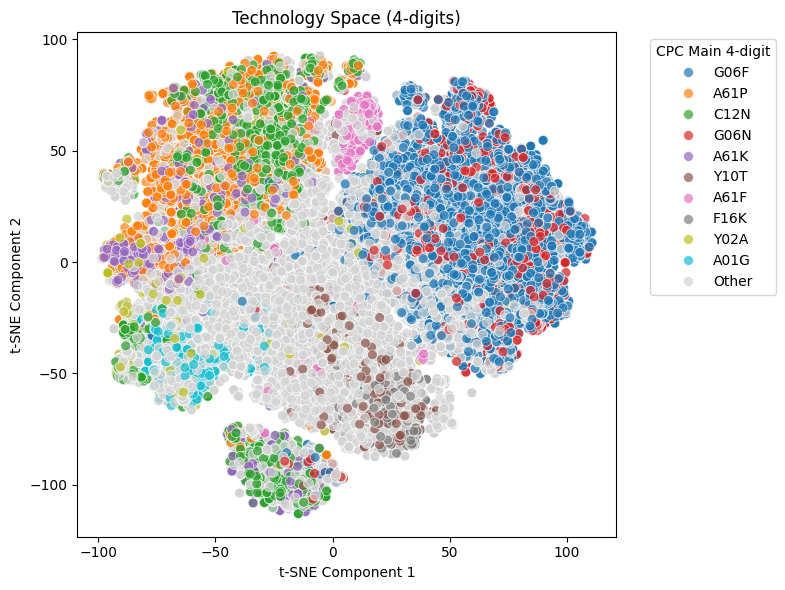

In [74]:
# Cell 12-(9-4): t-SNE by CPC Main 4-digit (Unknown Excluded)
# 1) Prepare cpc_main4
df_expl3["cpc_main4"] = df_expl3["cpc_main"].astype(str).str[:4]
mask4 = (
    df_expl3["cpc_main4"].notna()  # 실제 NaN 제거
    & (df_expl3["cpc_main4"] != "Unknown")
    & (df_expl3["cpc_main4"].str.lower() != "nan")
)

# # 2) t‑SNE projection
# tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
# X_tsne = tsne.fit_transform(X_all)

# 3) Filter and plot
vis4 = pd.DataFrame({
    "tSNE1":     X_tsne[mask4, 0],
    "tSNE2":     X_tsne[mask4, 1],
    "cpc_main4": df_expl3.loc[mask4, "cpc_main4"].values
})

# 4) Determine top 10 most frequent CPC codes
top10 = vis4["cpc_main4"].value_counts().nlargest(10).index.tolist()

# 5) Map each point to its code or 'Other'
vis4["label"] = vis4["cpc_main4"].where(vis4["cpc_main4"].isin(top10), "Other")

# 6) Prepare palette: tab10 for top10, gray for others
palette_top10 = sns.color_palette("tab10", len(top10))
color_map = {code: palette_top10[i] for i, code in enumerate(top10)}
color_map["Other"] = "lightgray"

# 7) Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=vis4,
    x="tSNE1", y="tSNE2",
    hue="label",
    hue_order=top10 + ["Other"],
    palette=color_map,
    alpha=0.7,
    s=50,
    edgecolor="white"
)
plt.title("Technology Space (4-digits)")
plt.xlabel("t‑SNE Component 1")
plt.ylabel("t‑SNE Component 2")
plt.legend(title="CPC Main 4‑digit", bbox_to_anchor=(1.05,1), loc="upper left")
plt.tight_layout()
plt.show()

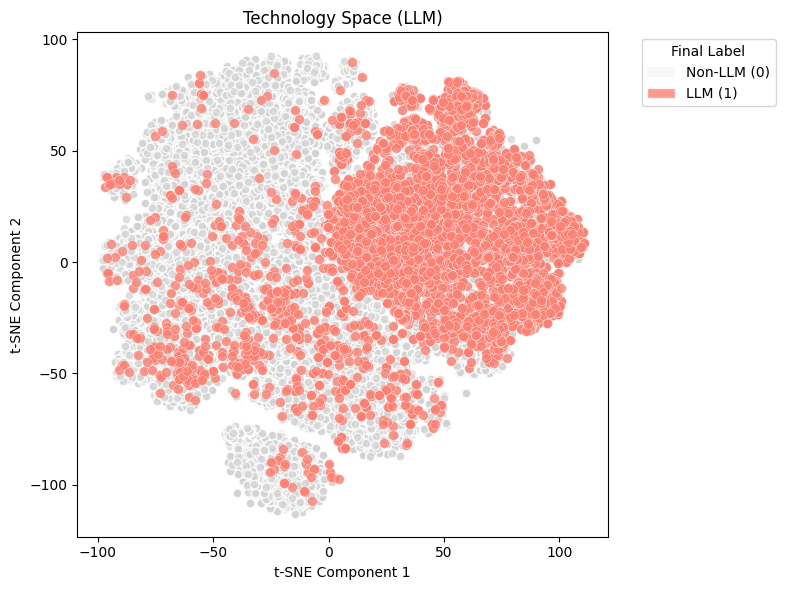

In [84]:
# Cell 12-(9-6)-tSNE: t‑SNE Projection Colored by Final Label

import matplotlib.patches as mpatches

# 0) Ensure embeddings X_all and df_expl3 are loaded; if not, recompute:
#    X_all = encode_texts(df_expl3["fulltext"].tolist(), batch_size=64)
#    (Make sure df_expl3 contains a 'final_label' column)

# # 1) Perform t‑SNE on the full embedding set X_all
# tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
# X_tsne = tsne.fit_transform(X_all)  # shape = (number of documents, 2)

# 1) Build DataFrame for plotting
vis_df_tsne = pd.DataFrame({
    "tSNE1":       X_tsne[:, 0],
    "tSNE2":       X_tsne[:, 1],
    "final_label": df_expl3["final_label"].values
})

# 2) 마스크 분리
mask_llm   = vis_df_tsne["final_label"] == 1
mask_other = ~mask_llm

plt.figure(figsize=(8, 6))

# 3) Non‑LLM 먼저 (투명 회색)
plt.scatter(
    vis_df_tsne.loc[mask_other, "tSNE1"],
    vis_df_tsne.loc[mask_other, "tSNE2"],
    c="lightgrey",
    alpha=0.75,
    s=40,
    edgecolors="white",
    label="Non‑LLM (0)"
)

# 4) LLM 나중에 (살몬)
plt.scatter(
    vis_df_tsne.loc[mask_llm, "tSNE1"],
    vis_df_tsne.loc[mask_llm, "tSNE2"],
    c="salmon",
    alpha=0.8,
    s=50,
    edgecolors="white",
    linewidths=0.3,
    label="LLM (1)"
)

# 5) 범례 커스텀(투명도 반영)
handles = [
    mpatches.Patch(facecolor="lightgray", alpha=0.15, edgecolor="none", label="Non‑LLM (0)"),
    mpatches.Patch(facecolor="salmon",    alpha=0.8,  edgecolor="white", label="LLM (1)")
]
plt.legend(handles=handles, title="Final Label", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.title("Technology Space (LLM)")
plt.xlabel("t‑SNE Component 1")
plt.ylabel("t‑SNE Component 2")
plt.tight_layout()
plt.show()


## **12-(10): Ensemble Modeling (0.5 x Logistic + 0.5 x MLP)**

In [85]:
# Cell 12-(10): Make Predictions (Logistic Regression ± MLP Ensemble) and Save to CSV

import numpy as np

# 1) Predict probabilities using the logistic regression model
log_proba_all = log_clf.predict_proba(X_all)[:, 1]  # Probability of class “LLM”

# 2) If an MLP model exists, combine its probabilities with the logistic output
if mlp is not None:
    import torch
    with torch.no_grad():
        # Compute MLP logits and convert to probabilities
        mlp_logits = mlp(torch.tensor(X_all, dtype=torch.float32).to(DEVICE))
        mlp_prob_all = torch.softmax(mlp_logits, dim=1)[:, 1].cpu().numpy()
    # Average the two model probabilities for ensemble
    use_prob = 0.5 * log_proba_all + 0.5 * mlp_prob_all
    print("Using ensemble of Logistic + MLP")
else:
    use_prob = log_proba_all
    print("Using Logistic only")

# 3) Store prediction results in a copy of the original DataFrame
df_logistic = df_expl3.copy()                          # Create a DataFrame copy
df_logistic["technology_confidence_raw"] = use_prob    # Save raw predicted probabilities
df_logistic["technology_type"] = np.where(
    use_prob >= 0.5, "LLM", "Others"
)  # Classify as “LLM” if probability ≥ 0.5, otherwise “Others”

# 4) Save the results to a CSV file for further analysis
df_logistic.to_csv("df_logistic_predictions.csv", index=False)  # Export without row indices


Using ensemble of Logistic + MLP


<Axes: ylabel='Frequency'>

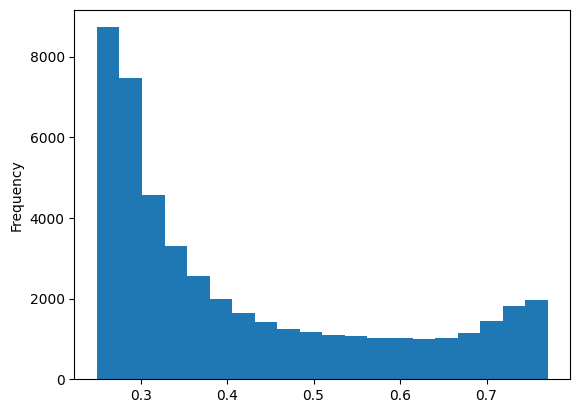

In [86]:
# (수치형일 경우 구간 빈도 보고 싶으면)
df_logistic["technology_confidence_raw"].plot.hist(bins=20)

In [87]:
# 결과 저장 (CSV) — 모든 컬럼 포함, 고정 파일명
out_base = base_dir if 'base_dir' in globals() else '.'
filename = "df_logistic_classification.csv"
out_path = os.path.join(out_base, filename)

df_logistic.to_csv(out_path, index=False, encoding="utf-8-sig")
print("저장 완료:", out_path)

저장 완료: /content/drive/My Drive/data1/df_logistic_classification.csv


In [88]:
# technology_type별 count와 ratio 간단히 표시
df = df_logistic["technology_type"].value_counts().to_frame("count")
df["ratio"] = (df["count"] / len(df_logistic)).round(3)
df

count  ratio
technology_type              
Others           33629  0.721
LLM              13007  0.279

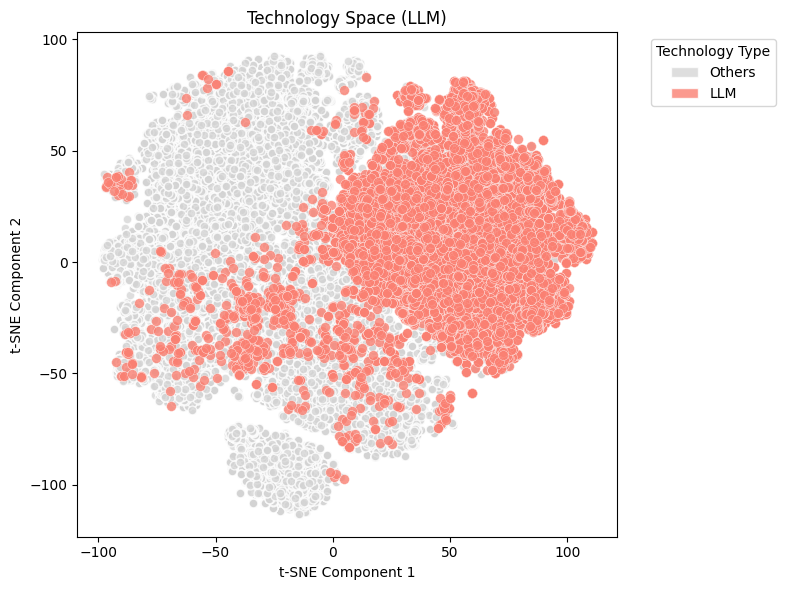

In [89]:
# Cell 13-(2)-tSNE: Technology Space (LLM) — df_logistic / technology_type
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.manifold import TSNE
import pandas as pd

# 0) Ensure X_all (embeddings for df_logistic) exists; otherwise compute it first.
#    X_all = encode_texts(df_logistic["fulltext"].tolist(), batch_size=64)

# 1) Run t-SNE (comment out if X_tsne already exists)
# tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
# X_tsne = tsne.fit_transform(X_all)

# 2) Build DataFrame for plotting
vis_df_tsne = pd.DataFrame({
    "tSNE1":           X_tsne[:, 0],
    "tSNE2":           X_tsne[:, 1],
    "technology_type": df_logistic["technology_type"].values
})

# 3) Split masks
mask_llm   = vis_df_tsne["technology_type"] == "LLM"
mask_other = ~mask_llm  # "Others"

plt.figure(figsize=(8, 6))

# 4) Plot Others first (transparent gray)
plt.scatter(
    vis_df_tsne.loc[mask_other, "tSNE1"],
    vis_df_tsne.loc[mask_other, "tSNE2"],
    c="lightgrey",
    alpha=0.75,
    s=40,
    edgecolors="white",
    label="Others"
)

# 5) Plot LLM on top (salmon)
plt.scatter(
    vis_df_tsne.loc[mask_llm, "tSNE1"],
    vis_df_tsne.loc[mask_llm, "tSNE2"],
    c="salmon",
    alpha=0.8,
    s=50,
    edgecolors="white",
    linewidths=0.3,
    label="LLM"
)

# 6) Custom legend (matching transparencies)
handles = [
    mpatches.Patch(facecolor="lightgrey", alpha=0.75, edgecolor="white", label="Others"),
    mpatches.Patch(facecolor="salmon",    alpha=0.8,  edgecolor="white", label="LLM")
]
plt.legend(handles=handles, title="Technology Type", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.title("Technology Space (LLM)")
plt.xlabel("t‑SNE Component 1")
plt.ylabel("t‑SNE Component 2")
plt.tight_layout()
plt.show()


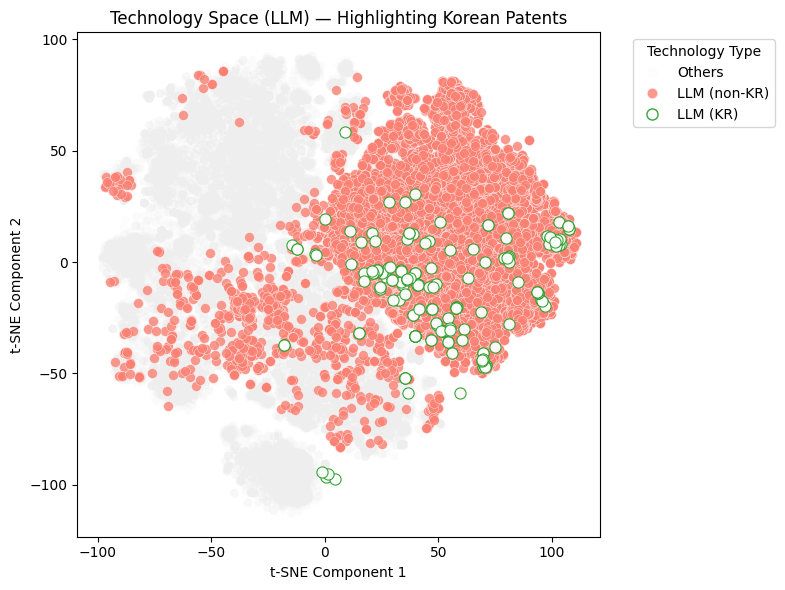

In [91]:
# Cell 13-(2)-tSNE: Technology Space (LLM) — Highlight KR within LLM

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.manifold import TSNE
import pandas as pd
from matplotlib.lines import Line2D


# 0) t-SNE 결과(X_tsne)와 df_logistic이 준비되어 있다고 가정
#    (없다면 X_all 재계산 후 X_tsne 생성 코드 먼저 실행)
#    vis_df_tsne를 새로 만들어 country_code 포함
vis_df_tsne = pd.DataFrame({
    "tSNE1":           X_tsne[:, 0],
    "tSNE2":           X_tsne[:, 1],
    "technology_type": df_logistic["technology_type"].values,
    "country_code":    df_logistic["country_code"].astype(str).values
})

# 1) 마스크 정의
mask_llm     = vis_df_tsne["technology_type"] == "LLM"
mask_kr      = mask_llm & (vis_df_tsne["country_code"] == "KR")
mask_llm_etc = mask_llm & ~mask_kr
mask_others  = ~mask_llm

plt.figure(figsize=(8, 6))

# 2) Others: 아주 옅은 회색
plt.scatter(
    vis_df_tsne.loc[mask_others, "tSNE1"],
    vis_df_tsne.loc[mask_others, "tSNE2"],
    c="#EEEEEE", alpha=0.07, s=35,
    edgecolors="none",
    label="Others"
)

# 3) LLM (KR 제외): 살몬
plt.scatter(
    vis_df_tsne.loc[mask_llm_etc, "tSNE1"],
    vis_df_tsne.loc[mask_llm_etc, "tSNE2"],
    c="salmon", alpha=0.8, s=50,
    edgecolors="white", linewidths=0.3,
    label="LLM (non‑KR)"
)

# 4) LLM (KR): 흰 내부 + 초록 테두리
plt.scatter(
    vis_df_tsne.loc[mask_kr, "tSNE1"],
    vis_df_tsne.loc[mask_kr, "tSNE2"],
    facecolors="white", edgecolors="#2ca02c",   # green
    linewidths=0.8, alpha=0.95, s=65,
    label="LLM (KR)"
)

# 5) 커스텀 범례
handles = [
    Line2D([0],[0], marker='o', linestyle='',
           markerfacecolor="#EEEEEE", markeredgecolor='none',
           alpha=0.07, markersize=8, label="Others"),
    Line2D([0],[0], marker='o', linestyle='',
           markerfacecolor="salmon", markeredgecolor='white',
           alpha=0.8, markersize=8, label="LLM (non‑KR)"),
    Line2D([0],[0], marker='o', linestyle='',
           markerfacecolor="white", markeredgecolor="#2ca02c",
           linewidth=0.8, alpha=0.95, markersize=8, label="LLM (KR)")
]
plt.legend(handles=handles, title="Technology Type",
           bbox_to_anchor=(1.05, 1), loc="upper left")

plt.title("Technology Space (LLM) — Highlighting Korean Patents")
plt.xlabel("t‑SNE Component 1")
plt.ylabel("t‑SNE Component 2")
plt.tight_layout()
plt.show()


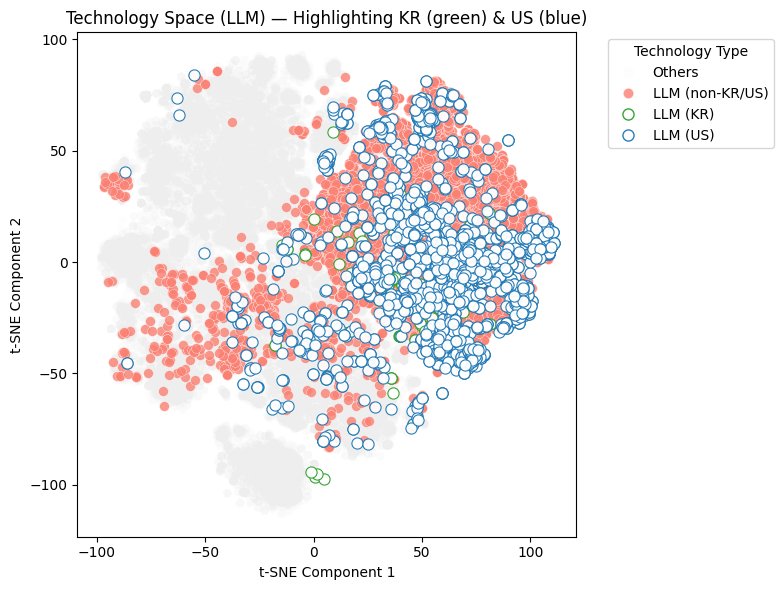

In [92]:
# Cell 13-(2)-tSNE: Technology Space (LLM) — Highlight KR(green) & US(blue)
# vis_df_tsne must have: tSNE1, tSNE2, technology_type, country_code
# vis_df_tsne = pd.DataFrame({
#     "tSNE1": X_tsne[:,0],
#     "tSNE2": X_tsne[:,1],
#     "technology_type": df_logistic["technology_type"].values,
#     "country_code": df_logistic["country_code"].astype(str).values
# })

# 1) Masks
mask_llm     = vis_df_tsne["technology_type"] == "LLM"
mask_kr      = mask_llm & (vis_df_tsne["country_code"] == "KR")
mask_us      = mask_llm & (vis_df_tsne["country_code"] == "US")
mask_llm_etc = mask_llm & ~mask_kr & ~mask_us
mask_others  = ~mask_llm

plt.figure(figsize=(8, 6))

# 2) Others: very light gray
plt.scatter(
    vis_df_tsne.loc[mask_others, "tSNE1"],
    vis_df_tsne.loc[mask_others, "tSNE2"],
    c="#EEEEEE", alpha=0.07, s=35,
    edgecolors="none", label="Others"
)

# 3) LLM (non KR/US): salmon
plt.scatter(
    vis_df_tsne.loc[mask_llm_etc, "tSNE1"],
    vis_df_tsne.loc[mask_llm_etc, "tSNE2"],
    c="salmon", alpha=0.8, s=50,
    edgecolors="white", linewidths=0.3,
    label="LLM (non‑KR/US)"
)

# 4) LLM (KR): white fill + green edge
plt.scatter(
    vis_df_tsne.loc[mask_kr, "tSNE1"],
    vis_df_tsne.loc[mask_kr, "tSNE2"],
    facecolors="white", edgecolors="#2ca02c",
    linewidths=0.8, alpha=0.95, s=65,
    label="LLM (KR)"
)

# 5) LLM (US): white fill + blue edge
plt.scatter(
    vis_df_tsne.loc[mask_us, "tSNE1"],
    vis_df_tsne.loc[mask_us, "tSNE2"],
    facecolors="white", edgecolors="#1f77b4",
    linewidths=0.8, alpha=0.95, s=65,
    label="LLM (US)"
)

# 6) Legend
handles = [
    Line2D([0],[0], marker='o', linestyle='', markerfacecolor="#EEEEEE",
           markeredgecolor='none', alpha=0.07, markersize=8, label="Others"),
    Line2D([0],[0], marker='o', linestyle='', markerfacecolor="salmon",
           markeredgecolor='white', alpha=0.8, markersize=8, label="LLM (non‑KR/US)"),
    Line2D([0],[0], marker='o', linestyle='', markerfacecolor="white",
           markeredgecolor="#2ca02c", linewidth=0.8, alpha=0.95, markersize=8, label="LLM (KR)"),
    Line2D([0],[0], marker='o', linestyle='', markerfacecolor="white",
           markeredgecolor="#1f77b4", linewidth=0.8, alpha=0.95, markersize=8, label="LLM (US)")
]
plt.legend(handles=handles, title="Technology Type",
           bbox_to_anchor=(1.05, 1), loc="upper left")

plt.title("Technology Space (LLM) — Highlighting KR (green) & US (blue)")
plt.xlabel("t‑SNE Component 1")
plt.ylabel("t‑SNE Component 2")
plt.tight_layout()
plt.show()


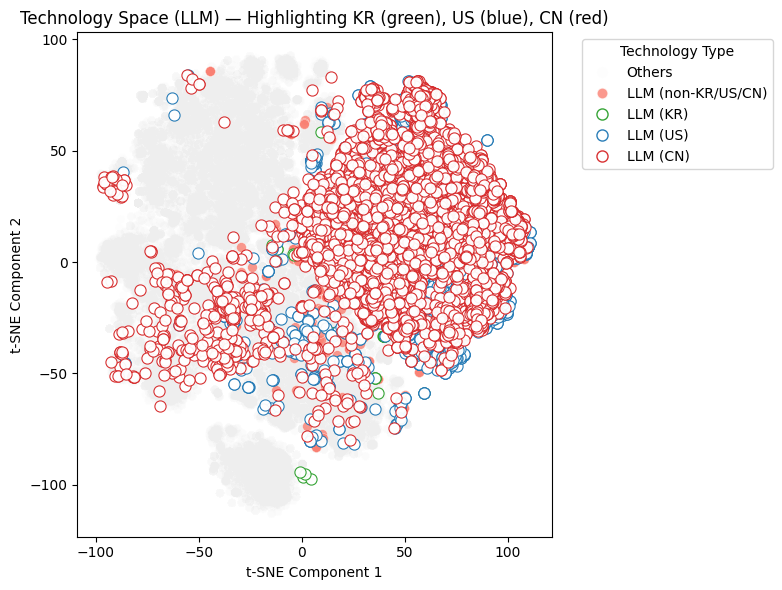

In [93]:
# Cell 13-(2)-tSNE: Technology Space (LLM) — Highlight KR(green), US(blue), CN(red)

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd

# vis_df_tsne must contain: tSNE1, tSNE2, technology_type, country_code
# Example:
# vis_df_tsne = pd.DataFrame({
#     "tSNE1":           X_tsne[:, 0],
#     "tSNE2":           X_tsne[:, 1],
#     "technology_type": df_logistic["technology_type"].values,
#     "country_code":    df_logistic["country_code"].astype(str).values
# })

# Masks
mask_llm     = vis_df_tsne["technology_type"] == "LLM"
mask_kr      = mask_llm & (vis_df_tsne["country_code"] == "KR")
mask_us      = mask_llm & (vis_df_tsne["country_code"] == "US")
mask_cn      = mask_llm & (vis_df_tsne["country_code"] == "CN")
mask_llm_etc = mask_llm & ~mask_kr & ~mask_us & ~mask_cn
mask_others  = ~mask_llm

plt.figure(figsize=(8, 6))

# Others (very light gray, high transparency)
plt.scatter(
    vis_df_tsne.loc[mask_others, "tSNE1"],
    vis_df_tsne.loc[mask_others, "tSNE2"],
    c="#EEEEEE", alpha=0.07, s=35,
    edgecolors="none", label="Others"
)

# LLM (non KR/US/CN) - salmon
plt.scatter(
    vis_df_tsne.loc[mask_llm_etc, "tSNE1"],
    vis_df_tsne.loc[mask_llm_etc, "tSNE2"],
    c="salmon", alpha=0.8, s=50,
    edgecolors="white", linewidths=0.3,
    label="LLM (non‑KR/US/CN)"
)

# LLM (KR) - white fill + green edge
plt.scatter(
    vis_df_tsne.loc[mask_kr, "tSNE1"],
    vis_df_tsne.loc[mask_kr, "tSNE2"],
    facecolors="white", edgecolors="#2ca02c",  # green
    linewidths=0.8, alpha=0.95, s=65,
    label="LLM (KR)"
)

# LLM (US) - white fill + blue edge
plt.scatter(
    vis_df_tsne.loc[mask_us, "tSNE1"],
    vis_df_tsne.loc[mask_us, "tSNE2"],
    facecolors="white", edgecolors="#1f77b4",  # blue
    linewidths=0.8, alpha=0.95, s=65,
    label="LLM (US)"
)

# LLM (CN) - white fill + red edge
plt.scatter(
    vis_df_tsne.loc[mask_cn, "tSNE1"],
    vis_df_tsne.loc[mask_cn, "tSNE2"],
    facecolors="white", edgecolors="#d62728",  # red
    linewidths=0.8, alpha=0.95, s=65,
    label="LLM (CN)"
)

# Custom legend
handles = [
    Line2D([0],[0], marker='o', linestyle='', markerfacecolor="#EEEEEE",
           markeredgecolor='none', alpha=0.07, markersize=8, label="Others"),
    Line2D([0],[0], marker='o', linestyle='', markerfacecolor="salmon",
           markeredgecolor='white', alpha=0.8, markersize=8, label="LLM (non‑KR/US/CN)"),
    Line2D([0],[0], marker='o', linestyle='', markerfacecolor="white",
           markeredgecolor="#2ca02c", linewidth=0.8, alpha=0.95, markersize=8, label="LLM (KR)"),
    Line2D([0],[0], marker='o', linestyle='', markerfacecolor="white",
           markeredgecolor="#1f77b4", linewidth=0.8, alpha=0.95, markersize=8, label="LLM (US)"),
    Line2D([0],[0], marker='o', linestyle='', markerfacecolor="white",
           markeredgecolor="#d62728", linewidth=0.8, alpha=0.95, markersize=8, label="LLM (CN)")
]
plt.legend(handles=handles, title="Technology Type",
           bbox_to_anchor=(1.05, 1), loc="upper left")

plt.title("Technology Space (LLM) — Highlighting KR (green), US (blue), CN (red)")
plt.xlabel("t‑SNE Component 1")
plt.ylabel("t‑SNE Component 2")
plt.tight_layout()
plt.show()


In [94]:
# Cell A: Prepare embeddings and t‑SNE coordinates

from sklearn.manifold import TSNE
import pandas as pd

# — df_logistic, X_all 은 이미 메모리에 있다고 가정합니다.
#    없다면 df_logistic을 다시 로드하고 X_all = encode_texts(df_logistic["fulltext"], batch_size=64) 로 만드세요.

# # 1) t‑SNE 계산
# tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
# X_tsne = tsne.fit_transform(X_all)

# 2) 시각화용 DataFrame 구성
vis_df_tsne = pd.DataFrame({
    "tSNE1":           X_tsne[:, 0],
    "tSNE2":           X_tsne[:, 1],
    "technology_type": df_logistic["technology_type"].values,
    "country_code":    df_logistic["country_code"].astype(str).values,
    "year":            df_logistic["year"].values
})

print("Prerequisites ready: vis_df_tsne shape =", vis_df_tsne.shape)


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Prerequisites ready: vis_df_tsne shape = (46636, 5)


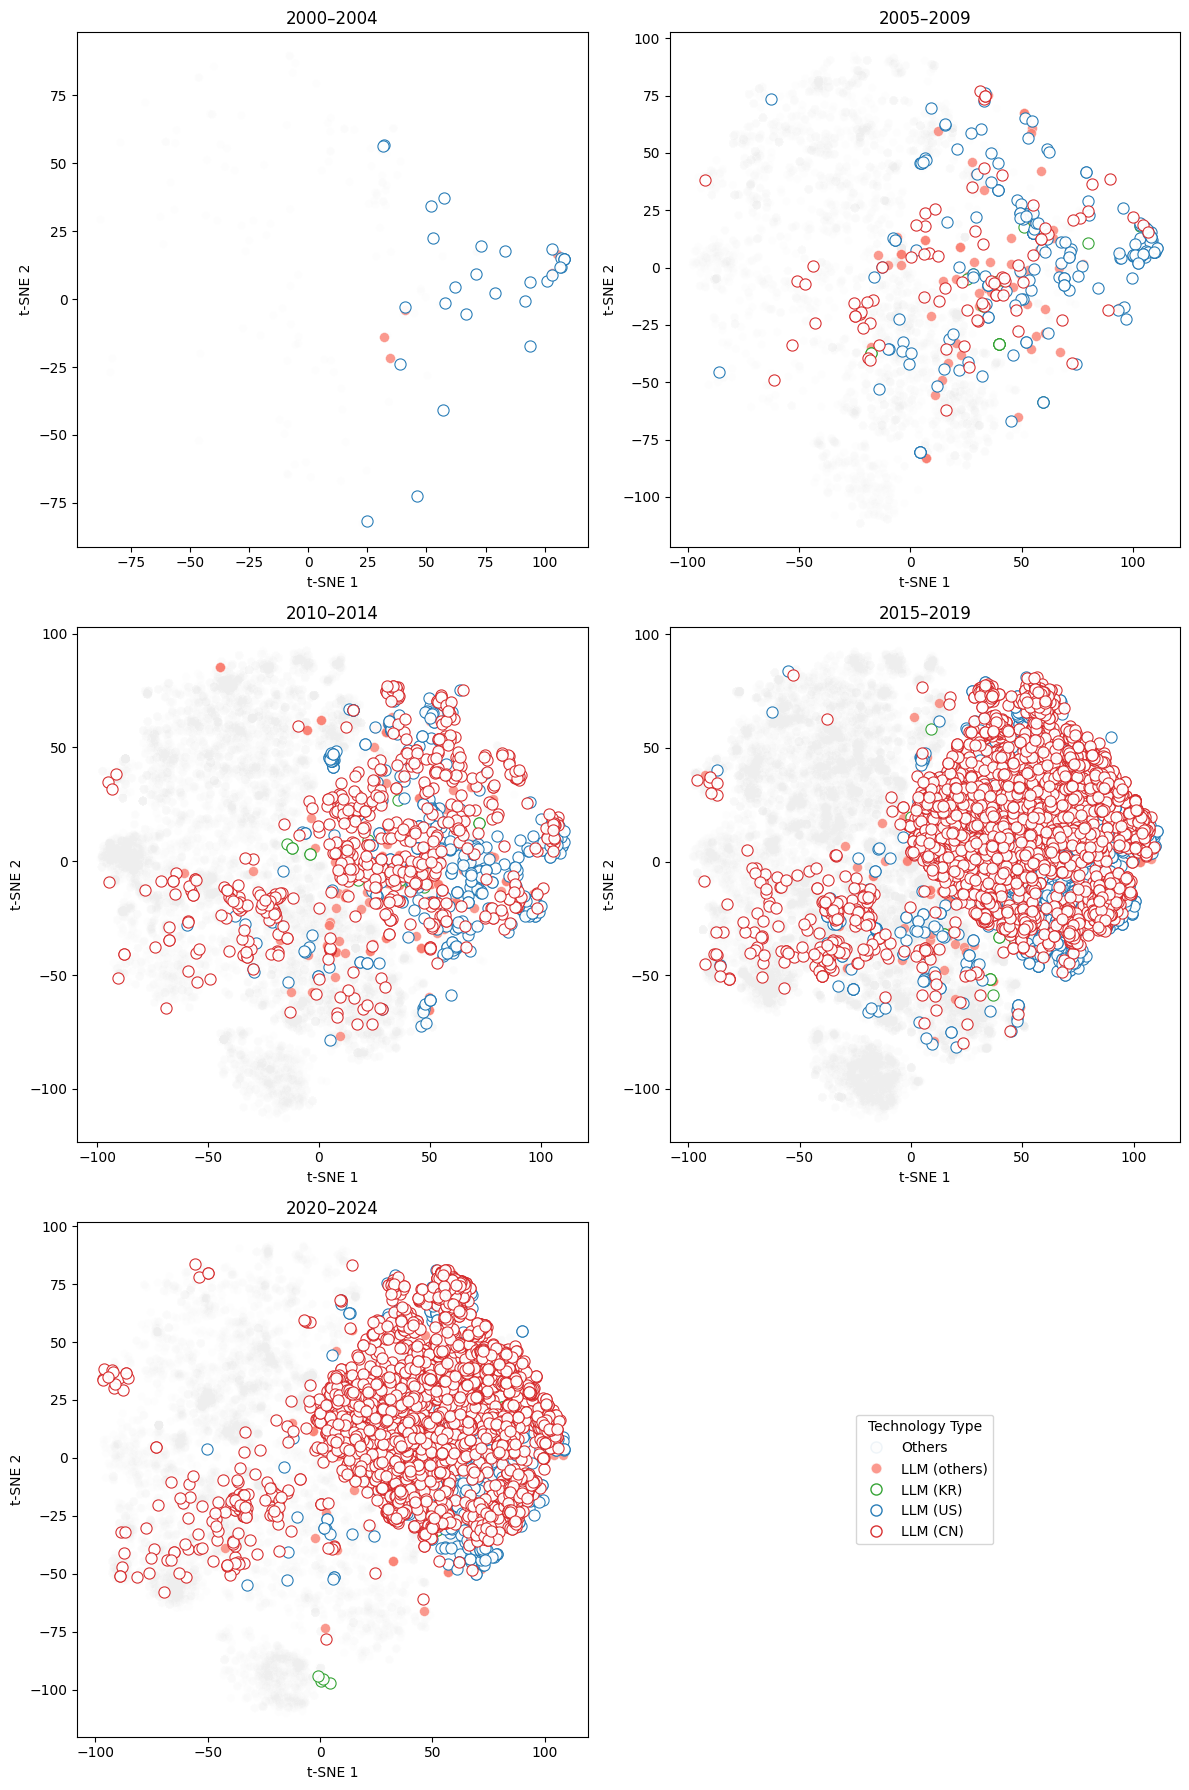

In [95]:
# Cell B: t‑SNE by 5-Year Periods

# 5‑year 구분 정의
periods = [
    ("2000–2004", range(2000, 2005)),
    ("2005–2009", range(2005, 2010)),
    ("2010–2014", range(2010, 2015)),
    ("2015–2019", range(2015, 2020)),
    ("2020–2024", range(2020, 2025))
]

fig, axes = plt.subplots(3, 2, figsize=(12, 18))
axes = axes.flatten()

for i, (label, yrs) in enumerate(periods):
    ax = axes[i]
    sub = vis_df_tsne[vis_df_tsne["year"].isin(yrs)]

    # 마스크
    m_llm    = sub["technology_type"] == "LLM"
    m_oth    = ~m_llm
    m_kr     = m_llm & (sub["country_code"] == "KR")
    m_us     = m_llm & (sub["country_code"] == "US")
    m_cn     = m_llm & (sub["country_code"] == "CN")
    m_etc    = m_llm & ~m_kr & ~m_us & ~m_cn

    # Others
    ax.scatter(sub.loc[m_oth, "tSNE1"], sub.loc[m_oth, "tSNE2"],
               c="#EEEEEE", alpha=0.07, s=35, edgecolors="none")
    # LLM others
    ax.scatter(sub.loc[m_etc, "tSNE1"], sub.loc[m_etc, "tSNE2"],
               c="salmon", alpha=0.8, s=50, edgecolors="white", linewidths=0.3)
    # KR
    ax.scatter(sub.loc[m_kr, "tSNE1"], sub.loc[m_kr, "tSNE2"],
               facecolors="white", edgecolors="#2ca02c",
               linewidths=0.8, alpha=0.95, s=65)
    # US
    ax.scatter(sub.loc[m_us, "tSNE1"], sub.loc[m_us, "tSNE2"],
               facecolors="white", edgecolors="#1f77b4",
               linewidths=0.8, alpha=0.95, s=65)
    # CN
    ax.scatter(sub.loc[m_cn, "tSNE1"], sub.loc[m_cn, "tSNE2"],
               facecolors="white", edgecolors="#d62728",
               linewidths=0.8, alpha=0.95, s=65)

    ax.set_title(label)
    ax.set_xlabel("t‑SNE 1")
    ax.set_ylabel("t‑SNE 2")

# 빈 6번째 축 제거
fig.delaxes(axes[-1])

# 범례 전용 축
leg_ax = fig.add_subplot(3, 2, 6)
leg_ax.axis('off')
handles = [
    Line2D([0],[0], marker='o', linestyle='', markerfacecolor="#EEEEEE", alpha=0.07, markersize=8, label="Others"),
    Line2D([0],[0], marker='o', linestyle='', markerfacecolor="salmon", markeredgecolor="white", alpha=0.8, markersize=8, label="LLM (others)"),
    Line2D([0],[0], marker='o', linestyle='', markerfacecolor="white", markeredgecolor="#2ca02c", alpha=0.95, markersize=8, label="LLM (KR)"),
    Line2D([0],[0], marker='o', linestyle='', markerfacecolor="white", markeredgecolor="#1f77b4", alpha=0.95, markersize=8, label="LLM (US)"),
    Line2D([0],[0], marker='o', linestyle='', markerfacecolor="white", markeredgecolor="#d62728", alpha=0.95, markersize=8, label="LLM (CN)")
]
leg_ax.legend(handles=handles, title="Technology Type", loc="center")

plt.tight_layout()
plt.show()


## **13-(4): Extract only records classified as LLM**

In [96]:

# Cell 13-(4): Extract only records classified as LLM and export them to CSV

# 1) Select rows where the predicted technology type is "LLM"
llm_df = df_logistic[df_logistic["technology_type"] == "LLM"].reset_index(drop=True)


In [98]:
llm_df.shape

(13007, 57)

## **13-(5): Filter df_network Using LLM Application IDs**

In [99]:
# Cell 13-(5): Filter df_network Using LLM Application IDs

# 1) Retrieve unique application IDs for patents classified as LLM
llm_appl_ids = llm_df["appl_id"].unique().tolist()

# 2) Subset the df_network DataFrame to include only rows corresponding to LLM patents
#    (Assumes df_network contains an 'appl_id' column linking edges or nodes to patent IDs)
df_network_llm = df_network[df_network["appl_id"].isin(llm_appl_ids)].copy()

# 3) (Optional) Display basic information about the filtered network
print(f"Filtered network contains {df_network_llm.shape[0]} rows and {df_network_llm.shape[1]} columns")
df_network_llm.head(1)


Filtered network contains 57956 rows and 50 columns


PTO_id PTO_type patent_kind pub_type_code  \
0     US       US           P            B2   

                                               title  \
0  Contextual safety assessment, recommendations,...   

                        title_en  \
0  문맥 안전 평가, 권장 사항, 프로비저닝 및 모니터링   

                                            abstract  \
0  Method and systems for identifying dangers in ...   

                                         abstract_en  \
0  액세스 가능한 환경에서 위험을 식별하기 위한 방법과 시스템. 컴퓨터 비전 및 비디오...   

                                          claim_main  \
0  1. A method to identify dangers in an accessib...   

                                       claim_main_en  ... orig_ipc_main  \
0  1. 접근 가능한 환경에서 위험을 식별하는 방법, 상기 방법은 다음을 포함한다:하나...  ...   G06K-009/62   

                                        orig_ipc_all  wintelips_key  \
0  G06K-009/62 | G06N-003/08 | G06F-016/903 | G06...   4.922037e+12   

  appl_date_parsed  year country_code          nats_raw        inventor_pre  \
0       2020-05-29  2020           US  [ZA, ZA, ZA, ZA]  Maletsabisa Molapo   

  applicant_nat_pre applicant  
0                US       IBM  

[1 rows x 50 columns]

In [125]:
llm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13007 entries, 0 to 13006
Data columns (total 57 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   PTO_id                     13007 non-null  object        
 1   PTO_type                   13007 non-null  object        
 2   patent_kind                13007 non-null  object        
 3   pub_type_code              13007 non-null  object        
 4   title                      13007 non-null  object        
 5   title_en                   13003 non-null  object        
 6   abstract                   13007 non-null  object        
 7   abstract_en                13002 non-null  object        
 8   claim_main                 13007 non-null  object        
 9   claim_main_en              13003 non-null  object        
 10  claims_indep               13007 non-null  object        
 11  claims_indep_en            13003 non-null  object        
 12  num_

In [100]:
# Display only the specified columns
df_network_llm[['appl_id', 'year', 'inventor', 'inventor_nat', 'country_code']]

appl_id  year                       inventor inventor_nat  \
0          16/887692  2020             MALETSABISA MOLAPO           ZA   
0          16/887692  2020           CHANE SIMONE MOODLEY           ZA   
0          16/887692  2020     SIBUSISIWE AUDREY MAKHANYA           ZA   
0          16/887692  2020  DARLINGTON SHINGIRIRAI MAPIYE           ZA   
5          17/160103  2021                   HUNG HAI BUI           VN   
...              ...   ...                            ...          ...   
46803  2016-10794627  2016                         CAO DI           CN   
46803  2016-10794627  2016                        CHEN LU           CN   
46803  2016-10794627  2016                       ZHENG DA           CN   
46804  2016-10656926  2016                        YUAN LI           CN   
46804  2016-10656926  2016                     GAN XINJUN           CN   

      country_code  
0               US  
0               US  
0               US  
0               US  
5               VN  
...            ...  
46803           CN  
46803           CN  
46803           CN  
46804           CN  
46804           CN  

[57956 rows x 5 columns]

## **14: Co‑Authorship Network (Only LLM Patents)**

In [128]:
# Cell 14: Co‑Authorship Network and Edge Weights (LLM Patents)

import networkx as nx   # Library for network creation and analysis

# 1) Define analysis period: years 2000 through 2023
year_sel = list(range(2000, 2024))

# 2) Extract unique inventor lists per patent
#    - Filter df_network_llm by the selected years
#    - Group by application ID and aggregate unique inventors
inventors_per_patent = (
    df_network_llm[df_network_llm['year'].isin(year_sel)]
        .groupby('appl_id')['inventor']
        .agg(lambda x: x.unique().tolist())
)

# 3) Create graph G_llm and add edges
#    - For each patent with two or more inventors, create edges between each pair
#    - If an edge already exists, increment its weight by 1; otherwise, add it with weight=1
G_llm = nx.Graph()
for inv_list in inventors_per_patent:
    if len(inv_list) < 2:
        continue  # Skip single‑inventor patents
    for i, a in enumerate(inv_list):
        for b in inv_list[i+1:]:
            if G_llm.has_edge(a, b):
                G_llm[a][b]['weight'] += 1
            else:
                G_llm.add_edge(a, b, weight=1)

# 4) Limit nodes to the top based on degree (weighted)
no_nodes = 500
deg_dict = dict(G_llm.degree(weight='weight'))                         # Compute weighted degree for each node
top_nodes = sorted(deg_dict, key=deg_dict.get, reverse=True)[:no_nodes]  # Select top nodes
G_sub = G_llm.subgraph(top_nodes).copy()                               # Create subgraph with selected nodes

# 5) Print summary of the resulting subgraph
print(f"▶︎ LLM subgraph nodes: {G_sub.number_of_nodes()}, edges: {G_sub.number_of_edges()}")


▶︎ LLM subgraph nodes: 500, edges: 2872


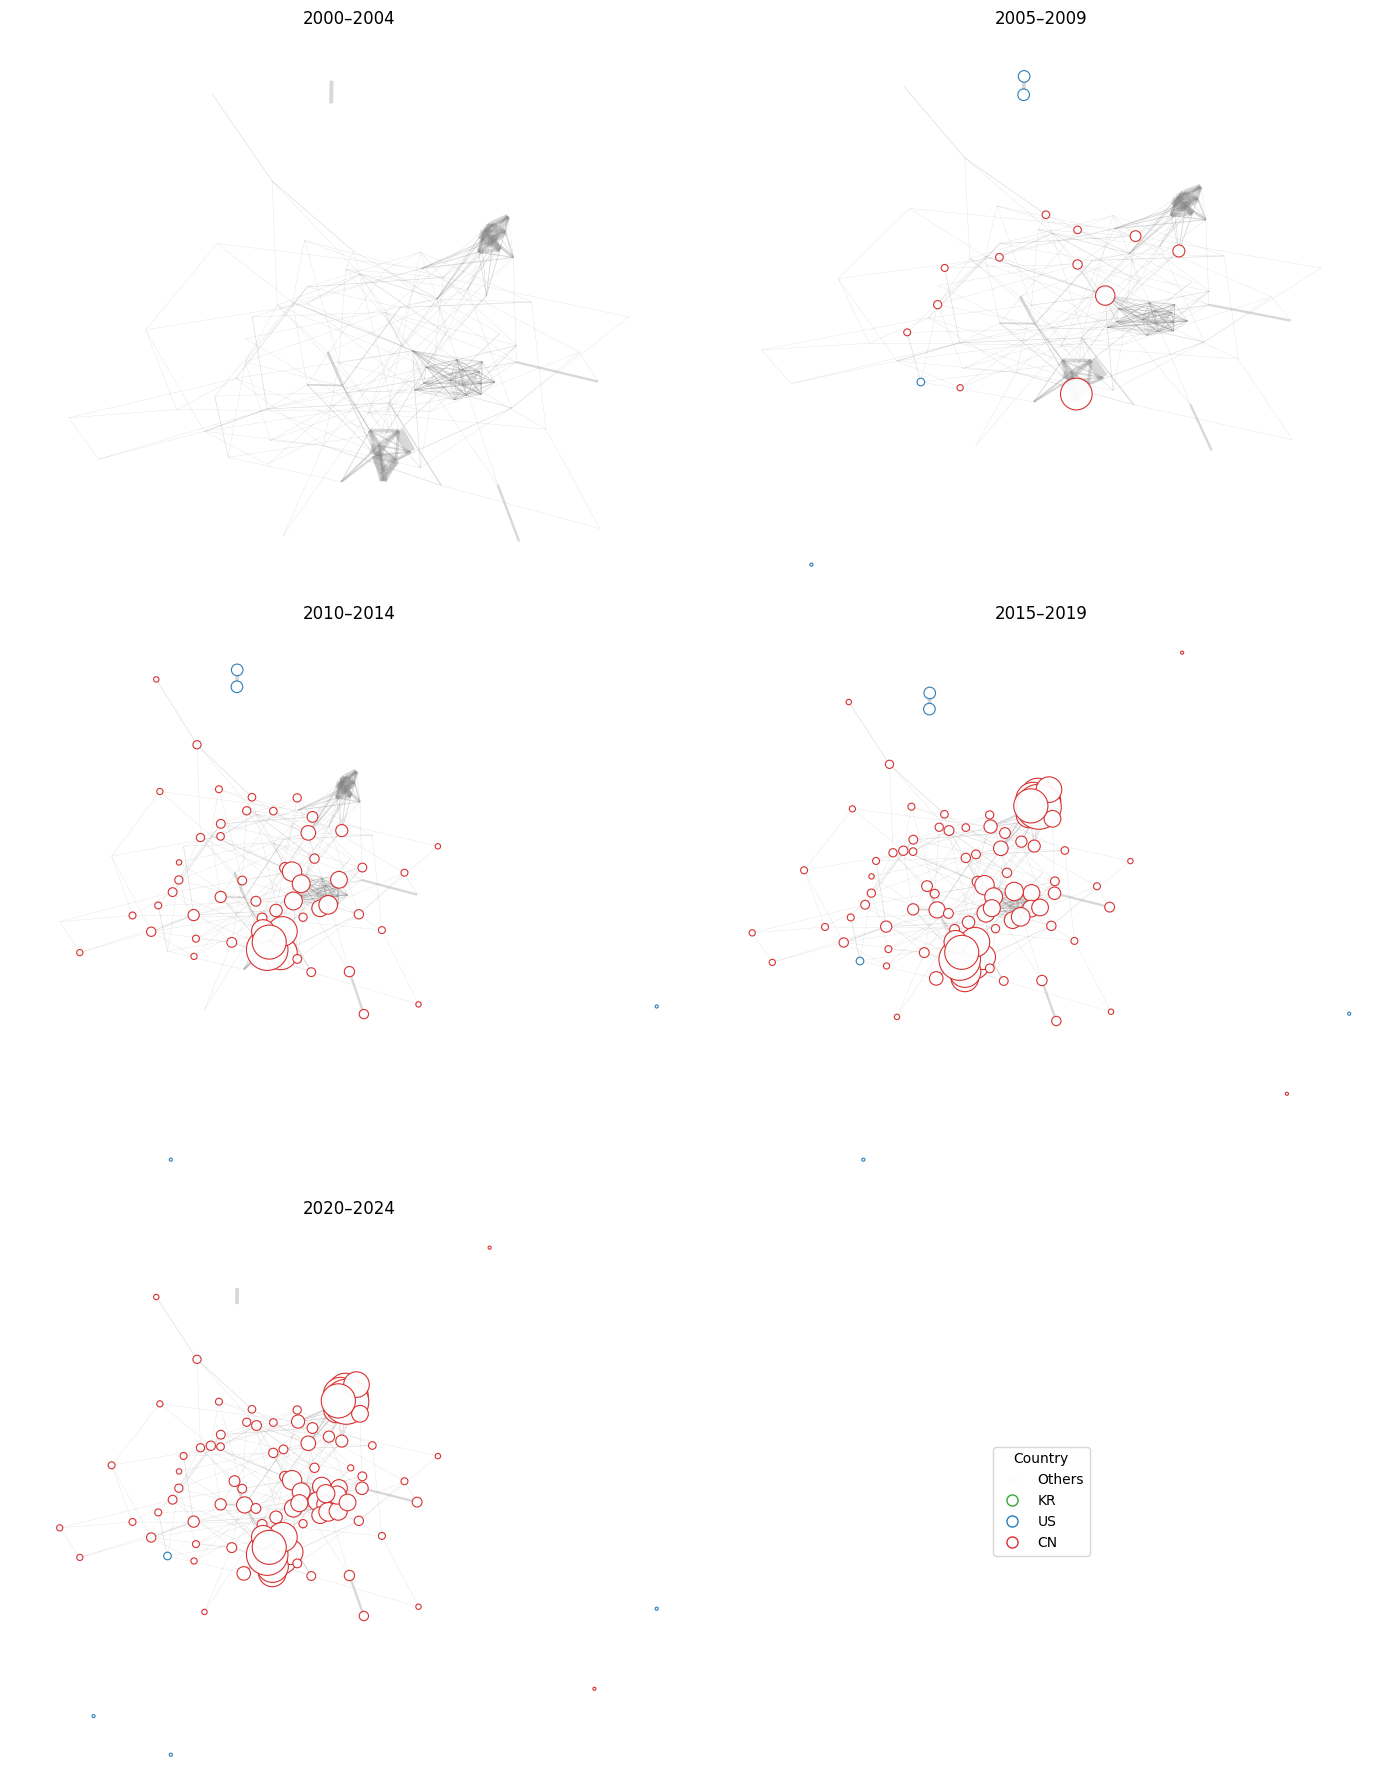

In [130]:
# Cell 12-(12e1)-Periodized Co‑Authorship Networks (Top 500 nodes, NO cutoff)

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import networkx as nx
import pandas as pd

# ───────────────────────────────────────────────────────────
# 0) Prerequisites
#    - df_network_llm: columns ['appl_id','inventor','year','inventor_nat', ...]
#    - G_llm: full co‑inventor graph (weighted) or rebuild it if missing
# ───────────────────────────────────────────────────────────
# If G_llm is not in memory, rebuild quickly:
# G_llm = nx.Graph()
# inv_lists = (df_network_llm
#              .groupby('appl_id')['inventor']
#              .agg(lambda x: x.unique().tolist()))
# for invs in inv_lists:
#     if len(invs) < 2: continue
#     for i,a in enumerate(invs):
#         for b in invs[i+1:]:
#             if G_llm.has_edge(a,b):
#                 G_llm[a][b]['weight'] += 1
#             else:
#                 G_llm.add_edge(a,b, weight=1)

# ───────────────────────────────────────────────────────────
# 1) Top 500 nodes by weighted degree (no cutoff)
# ───────────────────────────────────────────────────────────
deg_full = dict(G_llm.degree(weight='weight'))
top500 = sorted(deg_full, key=deg_full.get, reverse=True)[:100]
G = G_llm.subgraph(top500).copy()

# ───────────────────────────────────────────────────────────
# 2) 5-year periods
# ───────────────────────────────────────────────────────────
periods = [
    ("2000–2004", range(2000, 2005)),
    ("2005–2009", range(2005, 2010)),
    ("2010–2014", range(2010, 2015)),
    ("2015–2019", range(2015, 2020)),
    ("2020–2024", range(2020, 2025)),
]

# ───────────────────────────────────────────────────────────
# 3) Layout (fixed across all panels)
# ───────────────────────────────────────────────────────────
pos = nx.spring_layout(G, k=0.2, iterations=30, seed=42)

# ───────────────────────────────────────────────────────────
# 4) Country grouping & colors
# ───────────────────────────────────────────────────────────
def group_country(code: str):
    if code == "KR": return "KR"
    if code == "US": return "US"
    if code == "CN": return "CN"
    return "Others"

nat_map = {
    n: df_network_llm.loc[df_network_llm['inventor'] == n, 'inventor_nat'].iloc[0]
    for n in G.nodes()
}
country_map = {n: group_country(nat_map[n]) for n in G.nodes()}

colors = {
    "Others": "#EEEEEE",
    "KR":     "#2ca02c",
    "US":     "#1f77b4",
    "CN":     "#d62728",
}

# ───────────────────────────────────────────────────────────
# 5) Node sizes & edge widths (no cutoff)
# ───────────────────────────────────────────────────────────
deg = dict(G.degree(weight='weight'))
node_sizes = {n: (deg[n] + 1) * 5 for n in G.nodes()}

edges = [(u, v, d['weight']) for u, v, d in G.edges(data=True)]
max_w = max((w for *_, w in edges), default=1)
edgelist    = [(u, v) for u, v, _ in edges]
edge_widths = [w / max_w * 10 for *_, w in edges]

# ───────────────────────────────────────────────────────────
# 6) Inventor → years mapping (for period filtering)
# ───────────────────────────────────────────────────────────
inv_years = (
    df_network_llm.groupby('inventor')['year']
    .apply(lambda s: set(s.to_list()))
    .to_dict()
)

# ───────────────────────────────────────────────────────────
# 7) Plot: 3×2 grid (last pane used for legend)
# ───────────────────────────────────────────────────────────
fig, axes = plt.subplots(3, 2, figsize=(14, 18))
axes = axes.flatten()

for i, (title, yr_range) in enumerate(periods):
    ax = axes[i]
    active_inventors = {inv for inv, yrs in inv_years.items() if yrs & set(yr_range)}

    # Edges (all edges kept; thin & gray)
    nx.draw_networkx_edges(
        G, pos, edgelist=edgelist,
        width=edge_widths, edge_color='gray', alpha=0.3, ax=ax
    )

    # Nodes by group
    for grp in ["Others", "KR", "US", "CN"]:
        nodes_grp = [n for n in G.nodes() if country_map[n] == grp and n in active_inventors]
        if grp == "Others":
            ax.scatter(
                [pos[n][0] for n in nodes_grp],
                [pos[n][1] for n in nodes_grp],
                s=[node_sizes[n] for n in nodes_grp],
                c=colors[grp], alpha=0.07, edgecolors='none'
            )
        else:
            ax.scatter(
                [pos[n][0] for n in nodes_grp],
                [pos[n][1] for n in nodes_grp],
                facecolors='white', edgecolors=colors[grp],
                s=[node_sizes[n] for n in nodes_grp],
                linewidths=0.8, alpha=0.95
            )

    ax.set_title(title, fontsize=12)
    ax.axis('off')

# Use last subplot for legend
legend_ax = axes[-1]
legend_ax.axis('off')

handles = [
    Line2D([0], [0], marker='o', linestyle='', markersize=8,
           markerfacecolor=colors["Others"], markeredgecolor='none',
           alpha=0.07, label="Others"),
    Line2D([0], [0], marker='o', linestyle='', markersize=8,
           markerfacecolor='white', markeredgecolor=colors["KR"],
           linewidth=0.8, alpha=0.95, label="KR"),
    Line2D([0], [0], marker='o', linestyle='', markersize=8,
           markerfacecolor='white', markeredgecolor=colors["US"],
           linewidth=0.8, alpha=0.95, label="US"),
    Line2D([0], [0], marker='o', linestyle='', markersize=8,
           markerfacecolor='white', markeredgecolor=colors["CN"],
           linewidth=0.8, alpha=0.95, label="CN"),
]
legend_ax.legend(handles=handles, title="Country", loc='center')

plt.tight_layout()
plt.show()
